# Agent Benchmark Comparison

## Imports and Configuration

In [1]:
import pandas as pd
import json
from pathlib import Path
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import re # Added for regex parsing
import os
import ast

# Set current working directory
# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Set the working directory to the project root (one level up from the notebook directory)
project_root = os.path.join(notebook_dir, os.pardir)
os.chdir(project_root)

# You can verify the new working directory
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/timpi/Projects/thesis/multi_agent_supply_chain_optimization


In [2]:
# --- Directory specific imports ---
from utils import modify_and_run_model # New import

In [3]:
# --- Configuration --- 
BENCHMARK_PATH = Path('./benchmark/VRP/vrp_benchmark_10cust_2veh_50cap.csv')
AGENT_RUN_LOG_PATH = Path('./logs/run_log_20250530_190102.csv') # Example agent run log
MODEL_FILE_PATH = Path('./models/VRP/vrp_model.py')
MODEL_DATA_PATH = Path('./models/VRP/data/vrp_data_10cust_2veh_50cap.json')

benchmark_filepath = BENCHMARK_PATH
agent_log_filepath = AGENT_RUN_LOG_PATH
model_filepath = MODEL_FILE_PATH
model_data_filepath = MODEL_DATA_PATH

print(f"Loading benchmark from: {benchmark_filepath}")
print(f"Loading agent run log from: {agent_log_filepath}")
print(f"Using model file: {model_filepath}")
print(f"Using model data: {model_data_filepath}")

Loading benchmark from: benchmark/VRP/vrp_benchmark_10cust_2veh_50cap.csv
Loading agent run log from: logs/run_log_20250530_190102.csv
Using model file: models/VRP/vrp_model.py
Using model data: models/VRP/data/vrp_data_10cust_2veh_50cap.json


## Functions

In [4]:
### Helper functions
# --- Baseline Objective Calculation ---
def get_baseline_objective(model_file_path, model_data_path):
    print(f"Running baseline model from {model_file_path} with data {model_data_path}...")
    # Run the model with no modifications to get the baseline objective value
    # Log to a dedicated baseline log file
    baseline_log_filepath = "notebooks/baseline_vrp_log.csv"
    result = modify_and_run_model(
        modification_json={},
        model_file_path=str(model_file_path),
        model_data_path=str(model_data_path),
        run_id="baseline_run",
        log_filepath=baseline_log_filepath # Log to dedicated file
    )
    
    if isinstance(result, dict) and result.get('status') == 'Optimal':
        baseline_obj = result['total_cost']
        print(f"Baseline objective value: {baseline_obj}")
        return baseline_obj
    else:
        print(f"Failed to get optimal baseline objective: {result}")
        return None
    
# --- Read Baseline Log ---
def read_baseline_log(baseline_log_filepath):
    try:
        df_baseline = pd.read_csv(baseline_log_filepath)
        if not df_baseline.empty:
            print(f"Baseline log file loaded from {baseline_log_filepath}.")
            return df_baseline
        else:
            print("Baseline log file is empty.")
            return pd.DataFrame() # Return empty DataFrame
    except FileNotFoundError:
        print(f"Baseline log file not found at {baseline_log_filepath}. Please run baseline model first.")
        return pd.DataFrame() # Return empty DataFrame
    except Exception as e:
        print(f"Error reading baseline log: {e}")
        return pd.DataFrame() # Return empty DataFrame

# --- Read All CSVs in Folder (Updated to include run_group_label) ---
def read_all_csvs_in_folder(folder_path, exclude_patterns=None):
    """
    Reads all CSV files from a specified folder and its subfolders into a list of pandas DataFrames,
    excluding files that match any of the exclude patterns. Each DataFrame will have a new column
    'run_group_label' indicating the name of the immediate parent folder of the CSV.
    
    Args:
        folder_path (str or Path): The path to the folder containing CSV files.
        exclude_patterns (list[str], optional): A list of glob patterns for files to exclude.
                                                 Defaults to None.
        
    Returns:
        list[pd.DataFrame]: A list of DataFrames, one for each CSV file found and not excluded.
    """
    all_dfs = []
    folder_path = Path(folder_path) # Ensure it's a Path object
    
    if not folder_path.is_dir():
        print(f"Error: Folder not found at {folder_path}")
        return []
        
    all_csv_files = list(folder_path.glob("**/*.csv"))
    
    csv_files_to_read = []
    if exclude_patterns:
        for csv_file in all_csv_files:
            should_exclude = False
            for pattern in exclude_patterns:
                if csv_file.match(pattern):
                    print(f"Excluding {csv_file.name} as it matches pattern '{pattern}'")
                    should_exclude = True
                    break
            if not should_exclude:
                csv_files_to_read.append(csv_file)
    else:
        csv_files_to_read = all_csv_files

    if not csv_files_to_read:
        print(f"No CSV files found to read in {folder_path} or its subfolders (after exclusions).")
        return []
        
    print(f"Found {len(csv_files_to_read)} CSV files in {folder_path} and its subfolders. Reading them in...")
    
    for csv_file in sorted(csv_files_to_read):
        try:
            df = pd.read_csv(csv_file)
            # Extract the parent folder name as the run_group_label
            # Assuming the structure is logs/VRP/RUN_GROUP_LABEL/run_log_*.csv
            run_group_label = csv_file.parent.name 
            df['run_group_label'] = run_group_label
            all_dfs.append(df)
            print(f"Successfully read {csv_file.name} with group '{run_group_label}'")
        except Exception as e:
            print(f"Error reading {csv_file.name}: {e}")
            
    return all_dfs

# --- Modification JSON Parsing ---
def parse_modification_json(df, col_name='modification'):
    parsed_data = []
    for _, row in df.iterrows():
        try:
            mod_json = json.loads(row[col_name])
            mod_type = list(mod_json.keys())[0] if mod_json else None
            mod_value = mod_json[mod_type] if mod_type else None
            parsed_data.append({'modification_type': mod_type, 'modification_value': mod_value})
        except (json.JSONDecodeError, TypeError, IndexError):
            parsed_data.append({'modification_type': None, 'modification_value': None})
    return df.assign(**pd.DataFrame(parsed_data))

# --- 1. Ingestion & Normalization ---
def load_and_normalize_logs(benchmark_path, agent_log_path, baseline_objective):
    df_benchmark = pd.read_csv(benchmark_path)
    df_agent = pd.read_csv(agent_log_path)

    df_benchmark = parse_modification_json(df_benchmark, col_name='modification')
    df_agent = parse_modification_json(df_agent, col_name='code_modification')

    # Calculate delta_obj for both dataframes using the baseline
    if baseline_objective is not None:
        # Apply delta calculation only for 'Optimal' status
        df_benchmark['delta_obj'] = df_benchmark.apply(
            lambda row: row['objective_value'] - baseline_objective if row['status'] == 'Optimal' else np.nan,
            axis=1
        )
        df_agent['delta_obj'] = df_agent.apply(
            lambda row: row['objective_value'] - baseline_objective if row['status'] == 'Optimal' else np.nan,
            axis=1
        )
    else:
        print("Warning: Baseline objective not available. Delta objectives not calculated.")
        df_benchmark['delta_obj'] = np.nan
        df_agent['delta_obj'] = np.nan

    return df_benchmark, df_agent

# --- Canonical Scenario Key Creation ---
def create_canonical_key(params_data, constraints_data):
    """
    Creates a canonical, hashable key from parameters and constraints data.
    Handles JSON string, Python dictionary string (single quotes), and dictionary inputs.
    Ensures consistent ordering for comparison by converting all nested lists to tuples.
    """
    def make_hashable(obj):
        if isinstance(obj, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in obj.items()))
        elif isinstance(obj, list):
            return tuple(make_hashable(elem) for elem in obj)
        else:
            return obj

    def parse_and_make_hashable(data):
        if isinstance(data, str):
            try:
                # Try parsing as JSON (for benchmark)
                parsed = json.loads(data)
            except (json.JSONDecodeError, TypeError):
                try:
                    # Try parsing as Python literal (for agent)
                    parsed = ast.literal_eval(data)
                except (ValueError, SyntaxError, TypeError):
                    parsed = {} # Fallback for invalid string
        else:
            parsed = data if pd.notna(data) else {} # Assume it's already a dict or similar
        
        return make_hashable(parsed)

    params = parse_and_make_hashable(params_data)
    constraints = parse_and_make_hashable(constraints_data)

    # These are already hashable tuples from make_hashable
    # No need for sorted() here as make_hashable already sorts dict items
    return (params, constraints)

def format_latex_text(text, max_len=100):
    """
    Formats text for LaTeX: truncates if too long and escapes special characters.
    """
    if pd.isna(text):
        return ''
    text = str(text)
    if len(text) > max_len:
        text = text[:max_len-3] + '...'
    
    # Escape common LaTeX special characters
    # Order matters for some replacements (e.g., '\' before '_')
    text = text.replace('\\', '\\textbackslash{}') # Escape backslash first
    text = text.replace('_', '\\_')
    text = text.replace('%', '\\%')
    text = text.replace('&', '\\&')
    text = text.replace('#', '\\#')
    text = text.replace('{', '\\{')
    text = text.replace('}', '\\}')
    text = text.replace('~', '\\textasciitilde{}')
    text = text.replace('^', '\\textasciicircum{}')
    text = text.replace('$', '\\$') # Escape dollar signs for math mode
    
    # Replace < and > with math mode equivalents if they are not part of a command
    text = text.replace('<', '$<$').replace('>', '$>$')
    
    return text


## Data Analysis

### 1. Run baseline model

In [5]:
# Get baseline objective
baseline_obj_value = get_baseline_objective(model_filepath, model_data_filepath)
# Read the full baseline log
baseline_log_filepath = "notebooks/baseline_vrp_log.csv"
df_baseline_full = read_baseline_log(baseline_log_filepath)


Running baseline model from models/VRP/vrp_model.py with data models/VRP/data/vrp_data_10cust_2veh_50cap.json...
Baseline objective value: 330.1
Baseline log file loaded from notebooks/baseline_vrp_log.csv.


### 2. Import and add JSON modification split and objective value changes

In [6]:
df_benchmark, df_agent = load_and_normalize_logs(benchmark_filepath, agent_log_filepath, baseline_obj_value)

In [7]:
print("\nBenchmark DataFrame head:")
df_benchmark.head()


Benchmark DataFrame head:


,run_id,timestamp,status,objective_value,model_file_path,model_data_path,parameters,constraints,variables,pulp_model_execution_time,modification,scenario_text,scenario_type,placeholder_values,modification_type,modification_value,delta_obj
0,vrp_bench_20250531_212250_12,2025-05-31T21:22:52.209618,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 12.48, ""load_10"": 26...",0.003464,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 16/...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,"{""C"": 1, ""P"": 16}",ADD DATA,demand[1] = demand[1] * (1 + 16/100),0.000000e+00
1,vrp_bench_20250531_212250_1,2025-05-31T21:22:52.237603,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 39.15, ""load_10"": 31...",0.004388,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 5/1...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,"{""C"": 1, ""P"": 5}",ADD DATA,demand[1] = demand[1] * (1 + 5/100),5.684342e-14
2,vrp_bench_20250531_212250_8,2025-05-31T21:22:52.246289,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 39.36, ""load_10"": 31...",0.004501,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 12/...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,"{""C"": 1, ""P"": 12}",ADD DATA,demand[1] = demand[1] * (1 + 12/100),5.684342e-14
3,vrp_bench_20250531_212250_5,2025-05-31T21:22:52.293151,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 12.27, ""load_10"": 26...",0.007958,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 9/1...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,"{""C"": 1, ""P"": 9}",ADD DATA,demand[1] = demand[1] * (1 + 9/100),0.000000e+00
4,vrp_bench_20250531_212250_3,2025-05-31T21:22:52.412335,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 12.21, ""load_10"": 26...",0.003674,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 7/1...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,"{""C"": 1, ""P"": 7}",ADD DATA,demand[1] = demand[1] * (1 + 7/100),0.000000e+00


In [8]:
print("\nAgent DataFrame head:")
df_agent.head()


Agent DataFrame head:


,run_id,timestamp,status,objective_value,model_file_path,model_data_path,parameters,constraints,variables,pulp_model_execution_time,...,code_modification,planner_model,planner_temperature,coder_model,coder_temperature,agent_execution_time,delta_obj,token_usage,modification_type,modification_value
0,run_id_20250530_190102_it_0,2025-05-30T19:01:07.072700,Optimal,330.10,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 39.0, 'load_10': 31....",0.007408,...,"{""ADD DATA"": ""K = 4""}",gpt-4o-mini,0.7,gpt-4o,0.0,4.7012,5.684342e-14,"{""planner"": {""total"": 1509, ""prompt"": 1477, ""c...",ADD DATA,K = 4
1,run_id_20250530_190102_it_1,2025-05-30T19:01:23.705481,Optimal,416.89,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 17.0, 'load_10': 9.0...",0.003412,...,"{""ADD DATA"": ""Q = 30""}",gpt-4o-mini,0.7,gpt-4o,0.0,16.6241,8.679000e+01,"{""planner"": {""total"": 1570, ""prompt"": 1537, ""c...",ADD DATA,Q = 30
2,run_id_20250530_190102_it_2,2025-05-30T19:01:34.967024,Optimal,404.51,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 12.0, 'load_10': 26....",0.007287,...,"{""ADD DATA"": ""demand[2] = 20""}",gpt-4o-mini,0.7,gpt-4o,0.0,11.2581,7.441000e+01,"{""planner"": {""total"": 1642, ""prompt"": 1599, ""c...",ADD DATA,demand[2] = 20
3,run_id_20250530_190102_it_3,2025-05-30T19:01:37.391367,Infeasible,0.00,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 0.0, 'load_10': 0.0,...",0.005590,...,"{""ADD DATA"": ""Q = 20""}",gpt-4o-mini,0.7,gpt-4o,0.0,2.4238,NaN,"{""planner"": {""total"": 1710, ""prompt"": 1671, ""c...",ADD DATA,Q = 20
4,run_id_20250530_190102_it_4,2025-05-30T19:01:39.521131,Infeasible,0.00,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 0.0, 'load_10': 0.0,...",0.007183,...,"{""ADD DATA"": ""Q = 25""}",gpt-4o-mini,0.7,gpt-4o,0.0,2.1266,NaN,"{""planner"": {""total"": 1764, ""prompt"": 1726, ""c...",ADD DATA,Q = 25


In [9]:
### 2.1 Read All Agent Logs from a Folder (for cross-analysis)
# Define the folder path containing multiple agent run logs
# You can change this path to any folder with CSV logs you want to analyze together.
# Define the folder path containing multiple agent run logs
agent_logs_folder_path = Path('./logs/VRP')
# Define patterns for files to exclude
exclude_files = ['VRP_batch_summary.csv']

# Read all CSVs from the specified folder, excluding batch summary files
all_agent_dfs = read_all_csvs_in_folder(agent_logs_folder_path, exclude_patterns=exclude_files)

if all_agent_dfs:
    # Concatenate all DataFrames into a single DataFrame for cross-analysis
    df_all_agents = pd.concat(all_agent_dfs, ignore_index=True)
    print(f"\nSuccessfully concatenated {len(all_agent_dfs)} agent run logs into a single DataFrame.")
    print("Combined Agent Runs DataFrame head:")
    print(df_all_agents.head())
    
    # You can now perform cross-analysis on df_all_agents
    # For example, basic statistics across all runs:
    print("\nBasic statistics for combined agent runs:")
    print(df_all_agents[['objective_value', 'agent_execution_time', 'pulp_model_execution_time']].describe())
else:
    print("\nNo agent run logs were loaded from the specified folder.")

Found 37 CSV files in logs/VRP and its subfolders. Reading them in...
Successfully read run_log_20250603_012739.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o-mini_CT-0'
Successfully read run_log_20250603_012919.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o-mini_CT-0_5'
Successfully read run_log_20250603_013012.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o-mini_CT-1'
Successfully read run_log_20250603_011755.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-0'
Successfully read run_log_20250603_013134.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-0'
Successfully read run_log_20250603_013229.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-0_5'
Successfully read run_log_20250603_013331.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-1'
Successfully read run_log_20250603_012112.csv with group 'VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_

### 3. Data Exploration

In [10]:
# --- Status Statistics ---
print("\nBenchmark Scenario Status Distribution:")
print(df_benchmark['status'].value_counts())

# LaTeX Table for Benchmark Status Distribution
benchmark_status_df = df_benchmark['status'].value_counts().reset_index()
benchmark_status_df.columns = ['Status', 'Count']

# Test: Simple to_latex
print(benchmark_status_df.to_latex(index=False))


print("\nAgent Run Status Distribution:")
print(df_agent['status'].value_counts())

# LaTeX Table for Agent Run Status Distribution
agent_status_df = df_agent['status'].value_counts().reset_index()
agent_status_df.columns = ['status', 'Count']
print(agent_status_df.to_latex(index=False))



Benchmark Scenario Status Distribution:
status
Optimal       1077
Infeasible       4
Name: count, dtype: int64
\begin{tabular}{lr}
\toprule
Status & Count \\
\midrule
Optimal & 1077 \\
Infeasible & 4 \\
\bottomrule
\end{tabular}


Agent Run Status Distribution:
status
Optimal       12
Infeasible     8
Name: count, dtype: int64
\begin{tabular}{lr}
\toprule
status & Count \\
\midrule
Optimal & 12 \\
Infeasible & 8 \\
\bottomrule
\end{tabular}



In [11]:
# Parse the token_usage JSON column
df_agent['token_dict'] = df_agent['token_usage'].apply(json.loads)

# Extract planner and coder token counts
df_agent['planner_total_tokens']    = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('total', 0))
df_agent['planner_prompt_tokens']   = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('prompt', 0))
df_agent['planner_completion_tokens'] = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('completion', 0))
df_agent['planner_total_cost']    = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('total_cost', 0))
df_agent['coder_total_tokens']      = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('total', 0))
df_agent['coder_prompt_tokens']     = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('prompt', 0))
df_agent['coder_completion_tokens'] = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('completion', 0))
df_agent['coder_total_cost']    = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('total_cost', 0))

# Compute run-level metrics
metrics = {
    'Number of Runs': len(df_agent),
    'Total Planner Tokens': df_agent['planner_total_tokens'].sum(),
    'Total Planner Prompt Tokens': df_agent['planner_prompt_tokens'].sum(),
    'Total Planner Completion Tokens': df_agent['planner_completion_tokens'].sum(),
    'Total Planner Cost in USD': df_agent['planner_total_cost'].sum(),
    'Total Coder Tokens': df_agent['coder_total_tokens'].sum(),
    'Total Coder Prompt Tokens': df_agent['coder_prompt_tokens'].sum(),
    'Total Coder Completion Tokens': df_agent['coder_completion_tokens'].sum(),
    'Total Coder Cost in USD': df_agent['coder_total_cost'].sum(),
    'Total Tokens (Planner + Coder)': df_agent['planner_total_tokens'].sum() + df_agent['coder_total_tokens'].sum(),
    'Total Cost in USD (Planner + Coder)': df_agent['planner_total_cost'].sum() + df_agent['coder_total_cost'].sum(),
    'Minimum Objective Value': df_agent['objective_value'].min(),
    'Average Objective Value': df_agent['objective_value'].mean(),
    'Maximum Objective Value': df_agent['objective_value'].max(),
    'Average $\\Delta$Obj': df_agent['delta_obj'].mean() # Use LaTeX for Delta
}

# Display the metrics as a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print("\n--- Metrics Summary ---")
print(metrics_df)

# LaTeX Table for Metrics Summary
# Generate table body without header
latex_body_metrics_summary = metrics_df.to_latex(
    header=False, # Do not generate header automatically
    column_format='lr',
    float_format="%.4f" # Format numerical values
)

# Manually construct the full LaTeX table string
latex_metrics_summary = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Overall Agent Run Metrics Summary}}
\\label{{tab:overall_metrics_summary}}
\\small
\\begin{{tabular}}{{@{{}}lr@{{}}}}
\\toprule
\\textbf{{Metric}} & \\textbf{{Value}} \\\\
\\midrule
{latex_body_metrics_summary}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
print("\n--- LaTeX Table: Overall Agent Run Metrics Summary ---")
print(latex_metrics_summary)



--- Metrics Summary ---
                                             Value
Number of Runs                           20.000000
Total Planner Tokens                  42265.000000
Total Planner Prompt Tokens           41479.000000
Total Planner Completion Tokens         786.000000
Total Planner Cost in USD                 0.004476
Total Coder Tokens                    57852.000000
Total Coder Prompt Tokens             57488.000000
Total Coder Completion Tokens           364.000000
Total Coder Cost in USD                   0.080480
Total Tokens (Planner + Coder)       100117.000000
Total Cost in USD (Planner + Coder)       0.084956
Minimum Objective Value                   0.000000
Average Objective Value                 229.978240
Maximum Objective Value                 429.340000
Average $\Delta$Obj                      37.885833

--- LaTeX Table: Overall Agent Run Metrics Summary ---

\begin{table}[H]
\centering
\caption{Overall Agent Run Metrics Summary}
\label{tab:overall_metrics_sum

In [12]:
# Efficiency metrics
# Compute LLM overhead
df_agent['llm_overhead_sec'] = df_agent['agent_execution_time'] - df_agent['pulp_model_execution_time']

efficiency_summary = {
    'Avg Scenario Time (s)': df_agent['agent_execution_time'].mean(),
    'Avg Solver Time (s)': df_agent['pulp_model_execution_time'].mean(),
    'Avg LLM Overhead (s)': df_agent['llm_overhead_sec'].mean(),
    'Scenarios per Minute': 60 / df_agent['agent_execution_time'].mean(),
    'Avg Planner Tokens': df_agent['planner_total_tokens'].mean(),
    'Avg Coder Tokens': df_agent['coder_total_tokens'].mean(),
    'Avg Planner Cost (USD)': df_agent['planner_total_cost'].mean(),
    'Avg Coder Cost (USD)': df_agent['coder_total_cost'].mean(),
    'Cost-Impact Ratio (USD per |$\\Delta$Obj|)': (df_agent['planner_total_cost'] + df_agent['coder_total_cost']).sum() / df_agent['delta_obj'].abs().sum() # Use LaTeX for Delta
}
efficiency_df = pd.DataFrame.from_dict(efficiency_summary, orient='index', columns=['Value'])
print("\n--- Efficiency Metrics ---")
print(efficiency_df)

# LaTeX Table for Efficiency Metrics
# Generate table body without header
latex_body_efficiency_summary = efficiency_df.to_latex(
    header=False, # Do not generate header automatically
    column_format='lr',
    float_format="%.4f" # Format numerical values
)

# Manually construct the full LaTeX table string
latex_efficiency_summary = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Agent Run Efficiency Metrics Summary}}
\\label{{tab:efficiency_summary}}
\\small
\\begin{{tabular}}{{@{{}}lr@{{}}}}
\\toprule
\\textbf{{Metric}} & \\textbf{{Value}} \\\\
\\midrule
{latex_body_efficiency_summary}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
print("\n--- LaTeX Table: Agent Run Efficiency Metrics Summary ---")
print(latex_efficiency_summary)



--- Efficiency Metrics ---
                                                 Value
Avg Scenario Time (s)                         5.210850
Avg Solver Time (s)                           0.005706
Avg LLM Overhead (s)                          5.205144
Scenarios per Minute                         11.514436
Avg Planner Tokens                         2113.250000
Avg Coder Tokens                           2892.600000
Avg Planner Cost (USD)                        0.000224
Avg Coder Cost (USD)                          0.004024
Cost-Impact Ratio (USD per |$\Delta$Obj|)     0.000163

--- LaTeX Table: Agent Run Efficiency Metrics Summary ---

\begin{table}[H]
\centering
\caption{Agent Run Efficiency Metrics Summary}
\label{tab:efficiency_summary}
\small
\begin{tabular}{@{}lr@{}}
\toprule
\textbf{Metric} & \textbf{Value} \\
\midrule
\begin{tabular}{lr}
\toprule
\midrule
Avg Scenario Time (s) & 5.2108 \\
Avg Solver Time (s) & 0.0057 \\
Avg LLM Overhead (s) & 5.2051 \\
Scenarios per Minute & 11.5144 \

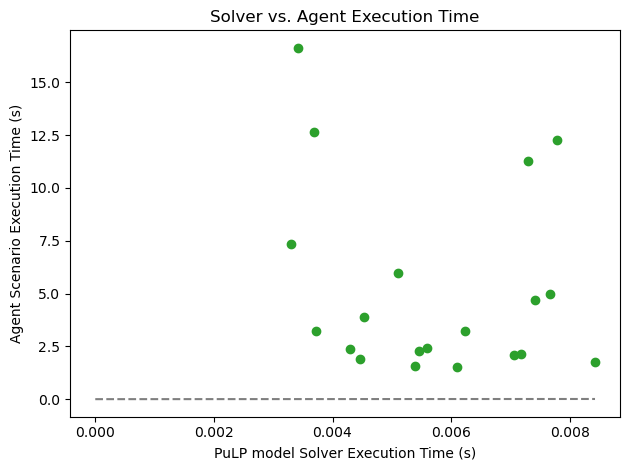

In [13]:
# Solver vs. Agent Execution Time
plt.figure()
plt.scatter(df_agent['pulp_model_execution_time'], df_agent['agent_execution_time'], c='tab:green')
plt.title('Solver vs. Agent Execution Time')
plt.xlabel('PuLP model Solver Execution Time (s)')
plt.ylabel('Agent Scenario Execution Time (s)')
plt.plot([0, df_agent['pulp_model_execution_time'].max()],
         [0, df_agent['pulp_model_execution_time'].max()], 'k--', alpha=0.5)
plt.tight_layout()

#### 3.1 Benchmark

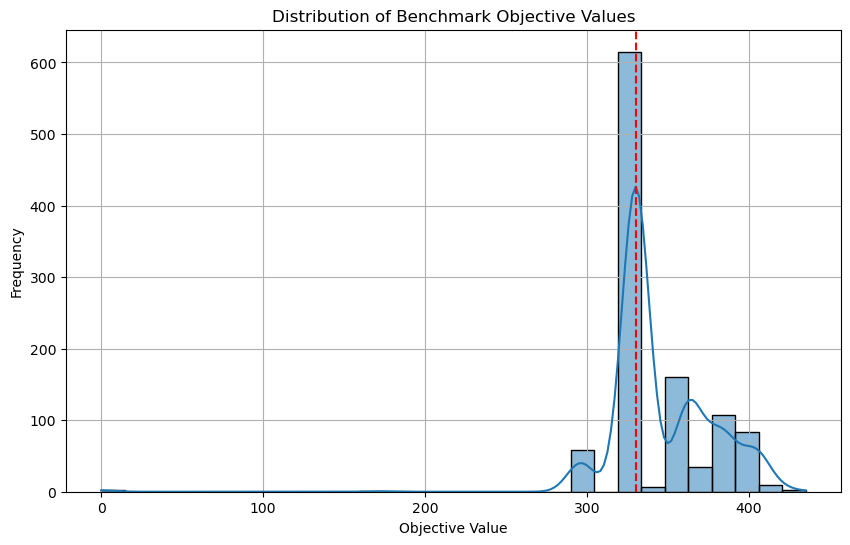

In [14]:
# Plotting Benchmark Objective Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_benchmark['objective_value'].dropna(), kde=True, bins=30)
plt.axvline(baseline_obj_value, color='red', linestyle='--', 
            label=f'Base objective: {baseline_obj_value:.2f}')
plt.title('Distribution of Benchmark Objective Values')
plt.xlabel('Objective Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

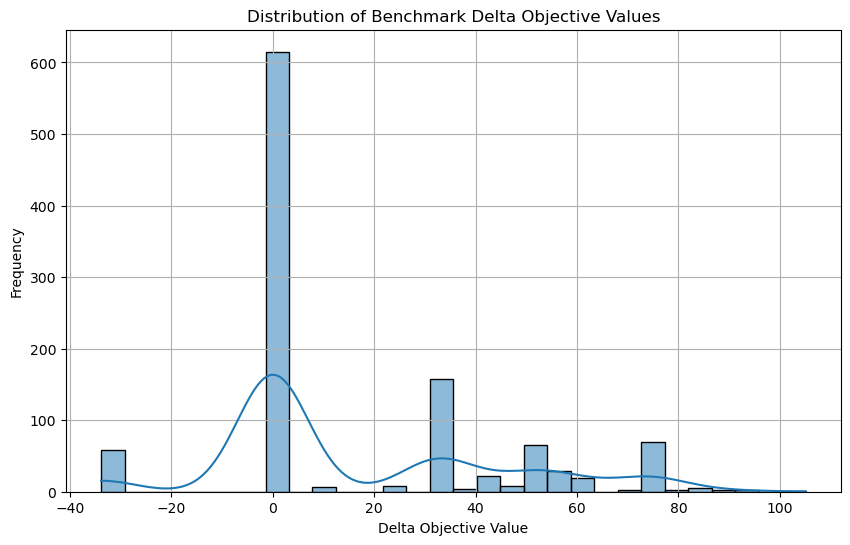

In [15]:
## Benchmark Analysis
# Plotting Benchmark Objective Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_benchmark['delta_obj'].dropna(), kde=True, bins=30)
plt.title('Distribution of Benchmark Delta Objective Values')
plt.xlabel('Delta Objective Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
# Displaying Top-K Benchmark Scenarios by Absolute Delta Objective Value
K = 10 # Define K for top scenarios
print(f"\nTop {K} Benchmark Scenarios by Absolute Delta Objective Value:")
top_k_benchmark = df_benchmark.sort_values(by='delta_obj', key=abs, ascending=False).head(K)
print(top_k_benchmark[['scenario_text', 'scenario_type', 'objective_value', 'delta_obj']])

# LaTeX Table for Top-K Benchmark Scenarios
# Apply formatting to scenario_text
top_k_benchmark_latex = top_k_benchmark[['scenario_text', 'scenario_type', 'objective_value', 'delta_obj']].copy()
top_k_benchmark_latex['scenario_text'] = top_k_benchmark_latex['scenario_text'].apply(format_latex_text, max_len=150) # Adjust max_len as needed

# Generate table body without header
latex_body_top_k_benchmark = top_k_benchmark_latex.to_latex(
    index=False,
    header=False, # Do not generate header automatically
    column_format='p{6cm}lrr', # Adjust column width for scenario text
    float_format="%.4f"
)

# Manually construct the full LaTeX table string
latex_top_k_benchmark = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Top {K} Benchmark Scenarios by Absolute Delta Objective Value}}
\\label{{tab:top_k_benchmark_scenarios}}
\\small
\\begin{{tabular}}{{@{{}}p{{6cm}}lrr@{{}}}}
\\toprule
\\textbf{{Scenario Text}} & \\textbf{{Scenario Type}} & \\textbf{{Objective Value}} & \\textbf{{$\\Delta$Obj}} \\\\
\\midrule
{latex_body_top_k_benchmark}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
print("\n--- LaTeX Table: Top-K Benchmark Scenarios ---")
print(latex_top_k_benchmark)



Top 10 Benchmark Scenarios by Absolute Delta Objective Value:
                                          scenario_text  \
763   Suppose vehicle capacity changed to 28. How do...   
1080         What if vehicle must traverse arc (10, 5)?   
1033         What if vehicle must traverse arc (5, 10)?   
616   What would happen if we changed the demand of ...   
760   Suppose vehicle capacity changed to 29. How do...   
765   Suppose vehicle capacity changed to 30. How do...   
1079         What if vehicle must traverse arc (10, 3)?   
1006         What if vehicle must traverse arc (3, 10)?   
1022          What if vehicle must traverse arc (5, 6)?   
1041          What if vehicle must traverse arc (6, 5)?   

                     scenario_type  objective_value  delta_obj  
763                capacity-change           435.18     105.08  
1080                     force-arc           424.12      94.02  
1033                     force-arc           424.12      94.02  
616   demand-increase-custo

#### 3.2 Agent

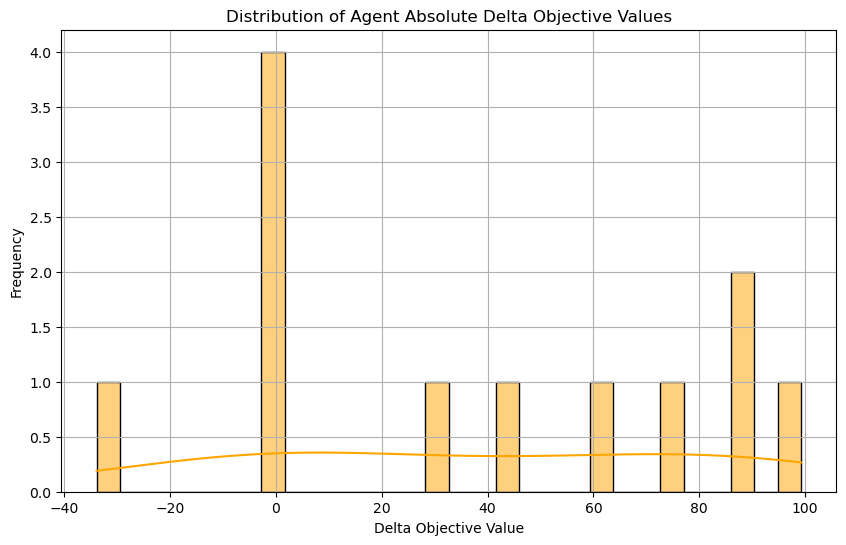

In [17]:
# Plotting Agent Absolute Delta Objective Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_agent['delta_obj'].dropna(), kde=True, bins=30, color='orange')
plt.title('Distribution of Agent Absolute Delta Objective Values')
plt.xlabel('Delta Objective Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [59]:
# Displaying Top-K Agent Scenarios by Absolute Delta Objective Value
K = 10 # Use the same K as for benchmark
print(f"\nTop {K} Agent Scenarios by Absolute Delta Objective Value:")
top_k_agent = df_agent.sort_values(by='delta_obj', key=abs, ascending=False).head(K)
print(top_k_agent[['scenario_text', 'objective_value', 'delta_obj', 'code_modification']])

# LaTeX Table for Top-K Agent Scenarios
# Apply formatting to scenario_text and code_modification
top_k_agent_latex = top_k_agent[['scenario_text', 'objective_value', 'delta_obj', 'code_modification']].copy()
top_k_agent_latex['scenario_text'] = top_k_agent_latex['scenario_text'].apply(format_latex_text, max_len=250) # Adjust max_len
top_k_agent_latex['code_modification'] = top_k_agent_latex['code_modification'].apply(format_latex_text, max_len=250) # Adjust max_len

# Generate table body without header
latex_body_top_k_agent = top_k_agent_latex.to_latex(
    index=False,
    header=False, # Do not generate header automatically
    column_format='p{4cm}rrp{4cm}', # Adjust column widths
    float_format="%.4f"
)

# Manually construct the full LaTeX table string
latex_top_k_agent = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Top {K} Agent Scenarios by Absolute Delta Objective Value}}
\\label{{tab:top_k_agent_scenarios}}
\\small
\\begin{{tabular}}{{@{{}}p{{4cm}}rrp{{4cm}}@{{}}}}
\\toprule
\\textbf{{Scenario Text}} & \\textbf{{Objective Value}} & \\textbf{{$\\Delta$Obj}} & \\textbf{{Code Modification}} \\\\
\\midrule
{latex_body_top_k_agent}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
print("\n--- LaTeX Table: Top-K Agent Scenarios ---")
print(latex_top_k_agent)



Top 10 Agent Scenarios by Absolute Delta Objective Value:
                                        scenario_text  objective_value  \
8   Scenario: 'Increase the demand of customer 6 f...           429.34   
11  Increase the demand of customer 9 from 5 to 50...           420.01   
1   Decrease the vehicle capacity from 50 to 30 to...           416.89   
2   Scenario: 'Increase the demand of customer 2 f...           404.51   
10  Increase the demand of customer 1 from 0 to 15...           393.39   
14  Increase the demand of customer 8 from 3 to 40...           372.46   
18  Increase the vehicle capacity from 50 to 70 wh...           296.26   
9   Increase the demand of customer 4 from 9 to 35...           362.57   
0   Increase the number of vehicles from 2 to 4 wh...           330.10   
6   Increase the demand of customer 5 from 9 to 25...           330.10   

       delta_obj               code_modification  
8   9.924000e+01  {"ADD DATA": "demand[6] = 30"}  
11  8.991000e+01  {"ADD 

#### 3.3 Check for any overlap between agent and benchmark

In [19]:
# Create canonical scenario keys
df_benchmark['scenario_key'] = df_benchmark.apply(
    lambda row: create_canonical_key(row['parameters'], row['constraints']), axis=1
    )
df_agent['scenario_key'] = df_agent.apply(
    lambda row: create_canonical_key(row['parameters'], row['constraints']), axis=1
)

In [20]:
df_benchmark['scenario_key'].head()

0    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
1    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
2    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
3    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
4    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
Name: scenario_key, dtype: object

In [21]:
df_agent['scenario_key'].head()

0    (((K, 4), (Q, 50), (coords, ((37.4540118847362...
1    (((K, 2), (Q, 30), (coords, ((37.4540118847362...
2    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
3    (((K, 2), (Q, 20), (coords, ((37.4540118847362...
4    (((K, 2), (Q, 25), (coords, ((37.4540118847362...
Name: scenario_key, dtype: object

In [22]:
# Matching Scenarios
# Merge agent runs with benchmark data based on scenario_key
# Use a left merge to keep all agent runs and find their corresponding benchmark
df_merged = pd.merge(
    df_agent,
    df_benchmark[['scenario_key', 'delta_obj', 'objective_value', 'scenario_text', 'scenario_type']].rename(
        columns={
            'delta_obj': 'benchmark_delta_obj',
            'objective_value': 'benchmark_objective_value',
            'scenario_text': 'benchmark_scenario_text',
            'scenario_type': 'benchmark_scenario_type'
        }
    ),
    on='scenario_key',
    how='left',
    suffixes=('_agent', '_benchmark')
)

#### 3.3.1 Matched Runs

In [23]:
# Assuming df_merged is available from previous analysis
# If not, you would need to ensure df_merged is created first, e.g.:
# df_merged = pd.merge(df_agent, df_benchmark, on='scenario_key', how='left', suffixes=('_agent', '_benchmark'))

matched_agent_runs = df_merged[df_merged['benchmark_delta_obj'].notna()]
print(f"\nNumber of agent runs found in benchmark: {len(matched_agent_runs)}") # Corrected print statement
print("\nMerged DataFrame head (showing matched scenarios):")
print(matched_agent_runs[['run_id', 'delta_obj', 'benchmark_delta_obj', 'benchmark_scenario_text']].head())

# LaTeX Table for Matched Agent Runs
matched_agent_runs_latex = matched_agent_runs[['run_id', 'delta_obj', 'benchmark_delta_obj', 'benchmark_scenario_text']].copy()
matched_agent_runs_latex['benchmark_scenario_text'] = matched_agent_runs_latex['benchmark_scenario_text'].apply(format_latex_text, max_len=150)

# Generate table body without header
latex_body_matched_runs = matched_agent_runs_latex.to_latex(
    index=False,
    header=False, # Do not generate header automatically
    column_format='lrrp{5cm}', # Adjust column width
    float_format="%.4f"
)

# Manually construct the full LaTeX table string
latex_matched_runs = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Examples of Agent Runs Matched with Benchmark Scenarios}}
\\label{{tab:matched_agent_runs}}
\\small
\\begin{{tabular}}{{@{{}}lrrp{{5cm}}@{{}}}}
\\toprule
\\textbf{{Run ID}} & \\textbf{{Agent $\\Delta$Obj}} & \\textbf{{Benchmark $\\Delta$Obj}} & \\textbf{{Benchmark Scenario Text}} \\\\
\\midrule
{latex_body_matched_runs}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
print("\n--- LaTeX Table: Matched Agent Runs ---")
print(latex_matched_runs)



Number of agent runs found in benchmark: 6

Merged DataFrame head (showing matched scenarios):
                          run_id     delta_obj  benchmark_delta_obj  \
0    run_id_20250530_190102_it_0  5.684342e-14         5.684342e-14   
1    run_id_20250530_190102_it_1  8.679000e+01         8.679000e+01   
2    run_id_20250530_190102_it_2  7.441000e+01         7.441000e+01   
6    run_id_20250530_190102_it_6  5.684342e-14         5.684342e-14   
10  run_id_20250530_190102_it_10  6.329000e+01         6.329000e+01   

                              benchmark_scenario_text  
0     What if we change the fleet size to 4 vehicles?  
1   Suppose vehicle capacity changed to 30. How do...  
2   What would happen if we changed the demand of ...  
6   What would happen if we changed the demand of ...  
10  What would happen if we changed the demand of ...  

--- LaTeX Table: Matched Agent Runs ---

\begin{table}[H]
\centering
\caption{Examples of Agent Runs Matched with Benchmark Scenarios}
\labe

#### 3.3.2 Unmatched Runs

In [60]:
# Flag unmatched agent runs (agent tried something not in benchmark)
unmatched_agent_runs = df_merged[df_merged['benchmark_delta_obj'].isna()]
print(f"\nNumber of agent runs not found in benchmark: {len(unmatched_agent_runs)}")
print("Examples of unmatched agent runs:")
# Updated print to include scenario_text for consistency
print(unmatched_agent_runs[['run_id', 'scenario_text', 'code_modification', 'delta_obj', 'status']].head())

# LaTeX Table for Unmatched Agent Runs
# Include 'scenario_text' in the DataFrame for LaTeX
unmatched_agent_runs_latex = unmatched_agent_runs[['run_id', 'scenario_text', 'code_modification', 'delta_obj', 'status']].copy()
unmatched_agent_runs_latex['scenario_text'] = unmatched_agent_runs_latex['scenario_text'].apply(format_latex_text) # Apply formatting
unmatched_agent_runs_latex['code_modification'] = unmatched_agent_runs_latex['code_modification'].apply(format_latex_text)

# Generate table body without header
latex_body_unmatched_runs = unmatched_agent_runs_latex.to_latex(
    index=False,
    header=False, # Do not generate header automatically
    column_format='lp{4cm}p{4cm}rl', # Adjusted column widths: Run ID, Scenario Text, Code Modification, Delta Obj, Status
    float_format="%.4f"
)

# Manually construct the full LaTeX table string
latex_unmatched_runs = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Examples of Agent Runs Not Found in Benchmark Scenarios}}
\\label{{tab:unmatched_agent_runs}}
\\small
\\begin{{tabular}}{{@{{}}lp{{4cm}}p{{4cm}}rl@{{}}}}
\\toprule
\\textbf{{Run ID}} & \\textbf{{Scenario Text}} & \\textbf{{Code Modification}} & \\textbf{{$\\Delta$Obj}} & \\textbf{{Status}} \\\\
\\midrule
{latex_body_unmatched_runs}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
print("\n--- LaTeX Table: Unmatched Agent Runs ---")
print(latex_unmatched_runs)



Number of agent runs not found in benchmark: 14
Examples of unmatched agent runs:
                        run_id  \
3  run_id_20250530_190102_it_3   
4  run_id_20250530_190102_it_4   
5  run_id_20250530_190102_it_5   
7  run_id_20250530_190102_it_7   
8  run_id_20250530_190102_it_8   

                                       scenario_text  \
3  Decrease the vehicle capacity from 50 to 20 to...   
4  Decrease the vehicle capacity from 50 to 25 to...   
5  Decrease the vehicle capacity from 50 to 15 to...   
7  Decrease the vehicle capacity from 50 to 10 to...   
8  Scenario: 'Increase the demand of customer 6 f...   

                code_modification  delta_obj      status  
3          {"ADD DATA": "Q = 20"}        NaN  Infeasible  
4          {"ADD DATA": "Q = 25"}        NaN  Infeasible  
5          {"ADD DATA": "Q = 15"}        NaN  Infeasible  
7          {"ADD DATA": "Q = 10"}        NaN  Infeasible  
8  {"ADD DATA": "demand[6] = 30"}      99.24     Optimal  

--- LaTeX Table: Unm

## 4. Performance Metrics

### 4.1 Top-K Coverage (Magnitude-based)

In [25]:
### 4.1 Top-K Coverage (Magnitude-based)

# Define K for top scenarios (can be adjusted)
K_coverage = 10 

# Get the top K benchmark scenarios by absolute delta_obj
top_k_benchmark_deltas = df_benchmark.sort_values(by='delta_obj', key=abs, ascending=False).head(K_coverage)

# Get the range of delta_obj values for these top K scenarios
# We'll consider the minimum and maximum absolute delta_obj from the top K
min_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().min()
max_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().max()

print(f"\nTop {K_coverage} Benchmark Scenarios (Absolute Delta Objective Range):")
print(f"Min Abs Delta: {min_top_k_abs_delta:.2f}, Max Abs Delta: {max_top_k_abs_delta:.2f}")

# Count how many agent scenarios fall within this range
# We consider an agent scenario "covered" if its absolute delta_obj is within the range
# of the top K benchmark scenarios.
agent_covered_by_magnitude = df_agent[
    (df_agent['delta_obj'].abs() >= min_top_k_abs_delta) & 
    (df_agent['delta_obj'].abs() <= max_top_k_abs_delta)
]

num_agent_covered = len(agent_covered_by_magnitude)
total_agent_scenarios = len(df_agent.dropna(subset=['delta_obj'])) # Only count scenarios with valid delta_obj

print(f"\nNumber of agent scenarios with absolute delta objective within Top {K_coverage} benchmark range: {num_agent_covered}")
if total_agent_scenarios > 0:
    percentage_covered = (num_agent_covered / total_agent_scenarios) * 100
    print(f"Percentage of agent scenarios covered by magnitude: {percentage_covered:.2f}%")
else:
    print("No valid agent scenarios to calculate percentage coverage.")

if not agent_covered_by_magnitude.empty:
    print("\nExamples of agent scenarios covered by magnitude:")
    print(agent_covered_by_magnitude[['run_id', 'delta_obj', 'code_modification']].head())





Top 10 Benchmark Scenarios (Absolute Delta Objective Range):
Min Abs Delta: 85.84, Max Abs Delta: 105.08

Number of agent scenarios with absolute delta objective within Top 10 benchmark range: 3
Percentage of agent scenarios covered by magnitude: 25.00%

Examples of agent scenarios covered by magnitude:
                          run_id  delta_obj               code_modification
1    run_id_20250530_190102_it_1      86.79          {"ADD DATA": "Q = 30"}
8    run_id_20250530_190102_it_8      99.24  {"ADD DATA": "demand[6] = 30"}
11  run_id_20250530_190102_it_11      89.91  {"ADD DATA": "demand[9] = 50"}


### 4.2 Sequential Performance Curves

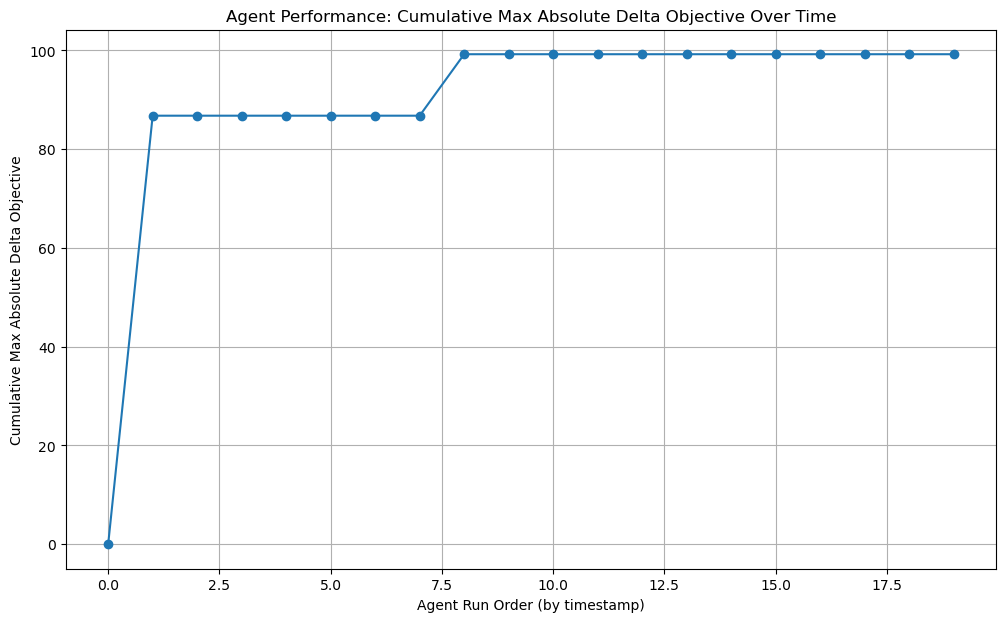

In [26]:
### 4.2 Sequential Performance Curves

# Ensure agent runs are sorted by timestamp for sequential analysis
df_agent_sorted = df_agent.sort_values(by='timestamp').copy()

# Calculate cumulative best-so-far absolute delta objective
df_agent_sorted['cumulative_max_abs_delta'] = df_agent_sorted['delta_obj'].abs().expanding().max()

plt.figure(figsize=(12, 7))
plt.plot(df_agent_sorted.index, df_agent_sorted['cumulative_max_abs_delta'], marker='o', linestyle='-')
plt.title('Agent Performance: Cumulative Max Absolute Delta Objective Over Time')
plt.xlabel('Agent Run Order (by timestamp)')
plt.ylabel('Cumulative Max Absolute Delta Objective')
plt.grid(True)
plt.show()

### 4.3 Absolute Ranking of Agent Scenarios within Benchmark Context

In [27]:
### 4.3 Absolute Ranking of Agent Scenarios within Benchmark Context

# Combine benchmark and agent scenarios for ranking
# We need to ensure unique identifiers if run_id's overlap, but for ranking,
# we can just combine their delta_obj values.
# Create a temporary DataFrame with relevant columns for ranking
df_combined_for_ranking = pd.DataFrame({
    'source': ['benchmark'] * len(df_benchmark) + ['agent'] * len(df_agent),
    'run_id': list(df_benchmark['run_id']) + list(df_agent['run_id']),
    'delta_obj': list(df_benchmark['delta_obj']) + list(df_agent['delta_obj'])
})

# Sort by absolute delta_obj in descending order to assign ranks
df_combined_for_ranking['abs_delta_obj'] = df_combined_for_ranking['delta_obj'].abs()
df_combined_for_ranking_sorted = df_combined_for_ranking.sort_values(by='abs_delta_obj', ascending=False).reset_index(drop=True)

# Assign rank
df_combined_for_ranking_sorted['rank'] = df_combined_for_ranking_sorted.index + 1

print("\nCombined Benchmark and Agent Scenarios with Absolute Ranks (Top 10):")
print(df_combined_for_ranking_sorted.head(10))


Combined Benchmark and Agent Scenarios with Absolute Ranks (Top 10):
      source                          run_id  delta_obj  abs_delta_obj  rank
0  benchmark   vrp_bench_20250531_212715_760     105.08         105.08     1
1      agent     run_id_20250530_190102_it_8      99.24          99.24     2
2  benchmark  vrp_bench_20250531_212820_1076      94.02          94.02     3
3  benchmark  vrp_bench_20250531_212813_1026      94.02          94.02     4
4      agent    run_id_20250530_190102_it_11      89.91          89.91     5
5  benchmark   vrp_bench_20250531_212716_761      86.79          86.79     6
6  benchmark   vrp_bench_20250531_212717_762      86.79          86.79     7
7  benchmark   vrp_bench_20250531_212535_610      86.79          86.79     8
8      agent     run_id_20250530_190102_it_1      86.79          86.79     9
9  benchmark  vrp_bench_20250531_212808_1004      86.13          86.13    10


In [28]:
# Filter for agent scenarios and show their ranks
agent_ranks = df_combined_for_ranking_sorted[df_combined_for_ranking_sorted['source'] == 'agent']
print("\nAgent Scenarios with their Absolute Ranks (Top 20):")
print(agent_ranks.head(20))

# You can also analyze specific agent runs' ranks
# For example, to find the rank of the most impactful agent scenario:
if not agent_ranks.empty:
    most_impactful_agent_run_rank = agent_ranks.iloc[0]['rank']
    print(f"\nRank of the most impactful agent scenario: {most_impactful_agent_run_rank}")



Agent Scenarios with their Absolute Ranks (Top 20):
     source                        run_id     delta_obj  abs_delta_obj  rank
1     agent   run_id_20250530_190102_it_8  9.924000e+01   9.924000e+01     2
4     agent  run_id_20250530_190102_it_11  8.991000e+01   8.991000e+01     5
8     agent   run_id_20250530_190102_it_1  8.679000e+01   8.679000e+01     9
57    agent   run_id_20250530_190102_it_2  7.441000e+01   7.441000e+01    58
89    agent  run_id_20250530_190102_it_10  6.329000e+01   6.329000e+01    90
221   agent  run_id_20250530_190102_it_14  4.236000e+01   4.236000e+01   222
256   agent  run_id_20250530_190102_it_18 -3.384000e+01   3.384000e+01   257
324   agent   run_id_20250530_190102_it_9  3.247000e+01   3.247000e+01   325
651   agent   run_id_20250530_190102_it_0  5.684342e-14   5.684342e-14   652
678   agent  run_id_20250530_190102_it_13  5.684342e-14   5.684342e-14   679
688   agent   run_id_20250530_190102_it_6  5.684342e-14   5.684342e-14   689
751   agent  run_id_202

Number of agent's scenarios ranked within the global top 10: 3
Out of 12 optimal scenarios generated by the agent, 25.00% ranked within the top 10 of all combined scenarios.


/tmp/ipykernel_13161/1876433705.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=plot_data, palette='coolwarm')


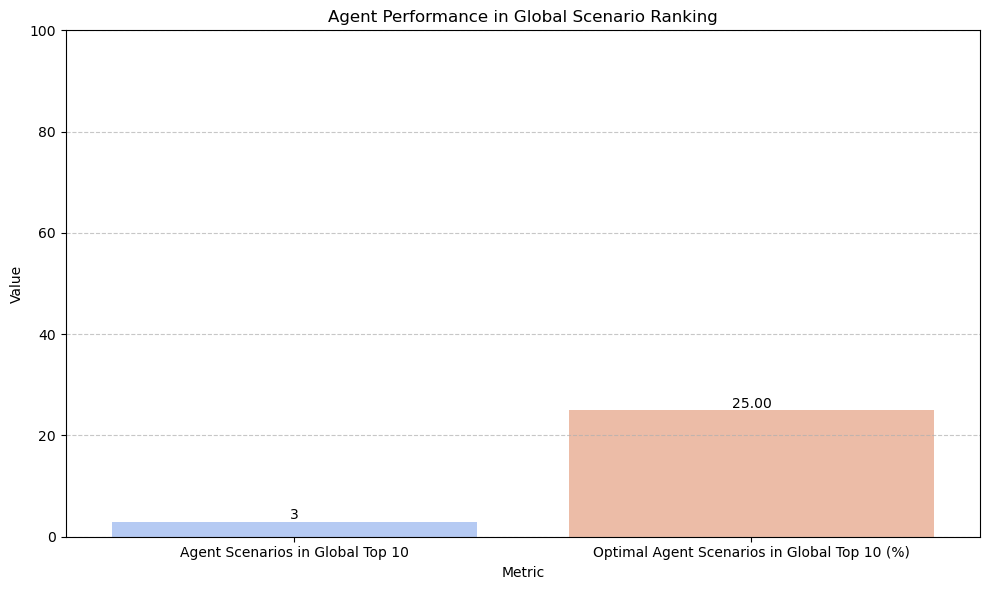

In [57]:
# Number of agent's scenarios within the global top 10
num_agent_in_global_top_10 = len(agent_ranks[agent_ranks['rank'] <= 10])
print(f"Number of agent's scenarios ranked within the global top 10: {num_agent_in_global_top_10}")

# Percentage of optimal agent scenarios within the global top X
GLOBAL_TOP_X = 10 # Define X for "global top X" as a variable, adjust as needed

# Get all optimal scenarios generated by the agent
optimal_agent_scenarios = df_agent[df_agent['status'] == 'Optimal'].copy()
total_optimal_agent_scenarios = len(optimal_agent_scenarios)

# Merge optimal agent scenarios with their global ranks
optimal_agent_scenarios_with_rank = pd.merge(
    optimal_agent_scenarios,
    df_combined_for_ranking_sorted[['run_id', 'rank']],
    on='run_id',
    how='left'
)

# Count how many of these optimal scenarios are within the global top X
optimal_agent_in_global_top_X = optimal_agent_scenarios_with_rank[
    optimal_agent_scenarios_with_rank['rank'] <= GLOBAL_TOP_X
]
num_optimal_agent_in_global_top_X = len(optimal_agent_in_global_top_X)

# Calculate the percentage
percentage_optimal_agent_in_global_top_X = (num_optimal_agent_in_global_top_X / total_optimal_agent_scenarios) * 100 if total_optimal_agent_scenarios > 0 else 0

print(f"Out of {total_optimal_agent_scenarios} optimal scenarios generated by the agent, {percentage_optimal_agent_in_global_top_X:.2f}% ranked within the top {GLOBAL_TOP_X} of all combined scenarios.")

# --- Bar Chart for Key Statistics ---
plot_data = pd.DataFrame({
    'Metric': [
        'Agent Scenarios in Global Top 10',
        f'Optimal Agent Scenarios in Global Top {GLOBAL_TOP_X} (%)'
    ],
    'Value': [
        num_agent_in_global_top_10,
        percentage_optimal_agent_in_global_top_X
    ]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', data=plot_data, palette='coolwarm')
plt.title('Agent Performance in Global Scenario Ranking')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(plot_data['Value'].max() * 1.1, 100 if ' (%)' in plot_data['Metric'].iloc[1] else plot_data['Value'].max() * 1.1)) # Adjust ylim
plt.tight_layout()

# Add value labels on top of bars
for index, row in plot_data.iterrows():
    plt.text(index, row['Value'] + (max(plot_data['Value']) * 0.02), 
             f"{row['Value']:.2f}" if ' (%)' in row['Metric'] else f"{int(row['Value'])}", 
             color='black', ha="center")

plt.show()

#### 5.4 Rank Correlations (Spearman)

/tmp/ipykernel_13161/1510565549.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_agent_runs['abs_delta_obj_agent'] = matched_agent_runs['delta_obj'].abs()
/tmp/ipykernel_13161/1510565549.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_agent_runs['abs_benchmark_delta_obj'] = matched_agent_runs['benchmark_delta_obj'].abs()



--- Matched Scenarios with Ranks (Head) ---
                                         scenario_key  abs_delta_obj_agent  \
0   (((K, 4), (Q, 50), (coords, ((37.4540118847362...         5.684342e-14   
1   (((K, 2), (Q, 30), (coords, ((37.4540118847362...         8.679000e+01   
2   (((K, 2), (Q, 50), (coords, ((37.4540118847362...         7.441000e+01   
6   (((K, 2), (Q, 50), (coords, ((37.4540118847362...         5.684342e-14   
10  (((K, 2), (Q, 50), (coords, ((37.4540118847362...         6.329000e+01   

    agent_rank  abs_benchmark_delta_obj  benchmark_rank  
0          5.5             5.684342e-14             5.5  
1          1.0             8.679000e+01             1.0  
2          2.0             7.441000e+01             2.0  
6          5.5             5.684342e-14             5.5  
10         3.0             6.329000e+01             3.0  

--- Rank Correlation Analysis ---
Number of matched scenarios used for correlation: 6
Spearman's Rank Correlation Coefficient: 1.0000
P-v

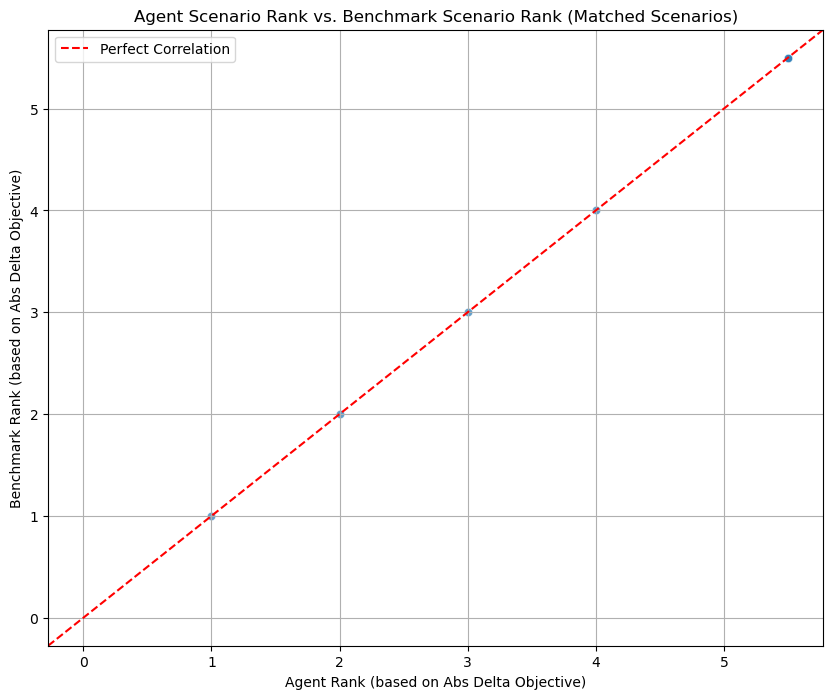


--- LaTeX Table: Rank Correlation Summary ---

\begin{table}[H]
\centering
\caption{Summary of Rank Correlation Between Agent and Benchmark Scenarios}
\label{tab:rank_correlation_summary}
\small
\begin{tabular}{@{}lr@{}}
\toprule
\textbf{Metric} & \textbf{Value} \\
\midrule
\begin{tabular}{lr}
\toprule
\midrule
Number of Matched Scenarios & 6.0000 \\
Spearman's Rank Correlation Coefficient & 1.0000 \\
P-value & 0.0000 \\
\bottomrule
\end{tabular}

\bottomrule
\end{tabular}
\end{table}



In [62]:
# --- 1. Identify Overlapping Scenarios ---
# Assuming df_merged has 'benchmark_delta_obj' column to identify matched scenarios
# If your df_merged uses 'delta_obj_agent' and 'benchmark_delta_obj', adjust column names below.
# For consistency, let's ensure we use the 'delta_obj' from df_agent and 'benchmark_delta_obj' from df_merged
# and that df_merged is based on scenario_key.

# Re-create matched_agent_runs for clarity if needed, or ensure it's available
# matched_agent_runs = df_merged[df_merged['benchmark_delta_obj'].notna()].copy()

# Ensure the columns for agent's delta and benchmark's delta are correctly named in matched_agent_runs
# If df_merged has 'delta_obj_agent' and 'benchmark_delta_obj', use those.
# If df_merged has 'delta_obj' (from agent) and 'benchmark_delta_obj', use those.
# Let's assume df_merged has 'delta_obj_agent' and 'benchmark_delta_obj' for clarity in this block.
# If your df_merged uses 'delta_obj' for agent's delta, replace 'delta_obj_agent' with 'delta_obj'.

# For this analysis, we need the absolute delta objectives for matched scenarios
# Let's ensure 'abs_delta_obj_agent' and 'abs_benchmark_delta_obj' are available
matched_agent_runs['abs_delta_obj_agent'] = matched_agent_runs['delta_obj'].abs()
matched_agent_runs['abs_benchmark_delta_obj'] = matched_agent_runs['benchmark_delta_obj'].abs()

# Drop rows where either delta is NaN (e.g., if status was not optimal)
matched_for_correlation = matched_agent_runs.dropna(subset=['abs_delta_obj_agent', 'abs_benchmark_delta_obj']).copy()

if matched_for_correlation.empty:
    print("\nNo matched scenarios with valid delta objectives for correlation analysis.")
else:
    # --- 2. Calculate Ranks for Overlapping Scenarios ---
    # Rank agent's absolute delta objectives (higher delta = higher rank/impact)
    matched_for_correlation['agent_rank'] = matched_for_correlation['abs_delta_obj_agent'].rank(ascending=False, method='average')
    
    # Rank benchmark's absolute delta objectives (higher delta = higher rank/impact)
    matched_for_correlation['benchmark_rank'] = matched_for_correlation['abs_benchmark_delta_obj'].rank(ascending=False, method='average')

    print("\n--- Matched Scenarios with Ranks (Head) ---")
    print(matched_for_correlation[['scenario_key', 'abs_delta_obj_agent', 'agent_rank', 'abs_benchmark_delta_obj', 'benchmark_rank']].head())

    # --- 3. Compute Spearman's Rank Correlation ---
    spearman_corr, p_value = spearmanr(matched_for_correlation['agent_rank'], matched_for_correlation['benchmark_rank'])

    print("\n--- Rank Correlation Analysis ---")
    print(f"Number of matched scenarios used for correlation: {len(matched_for_correlation)}")
    print(f"Spearman's Rank Correlation Coefficient: {spearman_corr:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The correlation is statistically significant (p < 0.05).")
    else:
        print("The correlation is not statistically significant (p >= 0.05).")

    # --- 4. Visualize Correlation (Scatter Plot) ---
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='agent_rank', y='benchmark_rank', data=matched_for_correlation, alpha=0.7)
    plt.title('Agent Scenario Rank vs. Benchmark Scenario Rank (Matched Scenarios)')
    plt.xlabel('Agent Rank (based on Abs Delta Objective)')
    plt.ylabel('Benchmark Rank (based on Abs Delta Objective)')
    plt.grid(True)
    plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Perfect Correlation') # Add a y=x line
    plt.legend()
    plt.show()

    # --- Optional: Generate LaTeX Table for Correlation Summary ---
    correlation_summary_data = {
        'Metric': ["Number of Matched Scenarios", "Spearman's Rank Correlation Coefficient", "P-value"],
        'Value': [len(matched_for_correlation), spearman_corr, p_value]
    }
    df_correlation_summary = pd.DataFrame(correlation_summary_data)

    latex_body_correlation_summary = df_correlation_summary.to_latex(
        index=False,
        header=False,
        column_format='lr',
        float_format="%.4f"
    )

    latex_correlation_summary = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Summary of Rank Correlation Between Agent and Benchmark Scenarios}}
\\label{{tab:rank_correlation_summary}}
\\small
\\begin{{tabular}}{{@{{}}lr@{{}}}}
\\toprule
\\textbf{{Metric}} & \\textbf{{Value}} \\\\
\\midrule
{latex_body_correlation_summary}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
    print("\n--- LaTeX Table: Rank Correlation Summary ---")
    print(latex_correlation_summary)


## 5. Efficiency & Cost Trade-Off

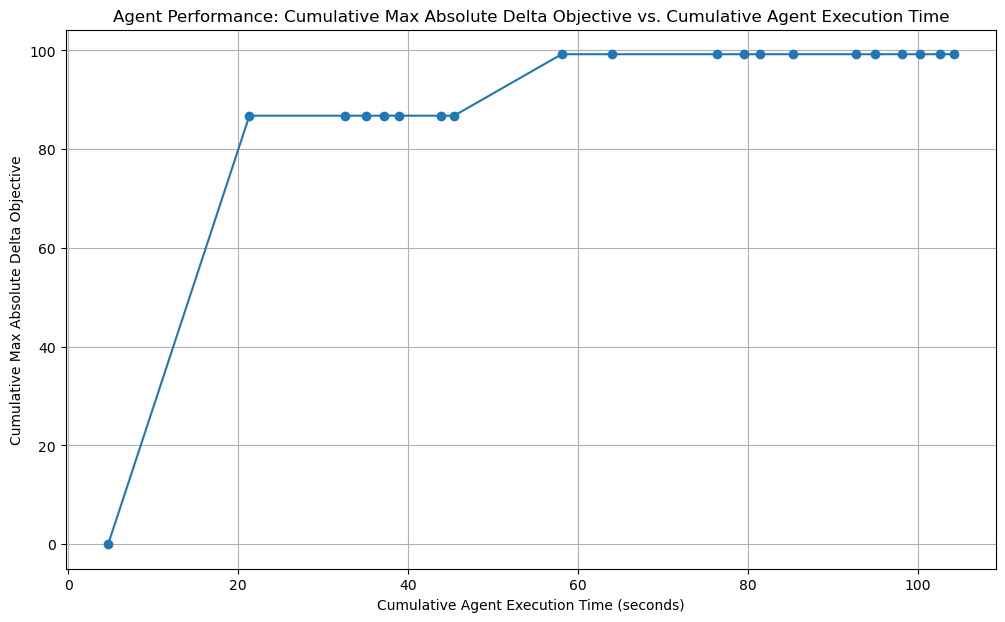

In [29]:
## 5. Efficiency & Cost Trade-Off

# Calculate cumulative agent execution time
df_agent_sorted['cumulative_agent_execution_time'] = df_agent_sorted['agent_execution_time'].cumsum()

# Calculate cumulative token usage
df_agent_sorted['cumulative_token_usage'] = df_agent_sorted['token_usage'].cumsum()

# Plot Cumulative Cost vs. Cumulative Max Absolute Delta
plt.figure(figsize=(12, 7))
plt.plot(df_agent_sorted['cumulative_agent_execution_time'], df_agent_sorted['cumulative_max_abs_delta'], marker='o', linestyle='-')
plt.title('Agent Performance: Cumulative Max Absolute Delta Objective vs. Cumulative Agent Execution Time')
plt.xlabel('Cumulative Agent Execution Time (seconds)')
plt.ylabel('Cumulative Max Absolute Delta Objective')
plt.grid(True)
plt.show()



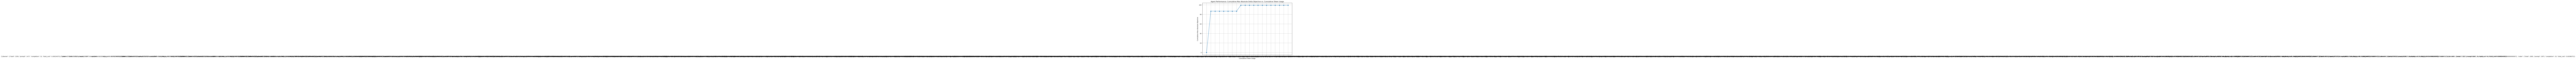

In [30]:
plt.figure(figsize=(12, 7))
plt.plot(df_agent_sorted['cumulative_token_usage'], df_agent_sorted['cumulative_max_abs_delta'], marker='o', linestyle='-')
plt.title('Agent Performance: Cumulative Max Absolute Delta Objective vs. Cumulative Token Usage')
plt.xlabel('Cumulative Token Usage')
plt.ylabel('Cumulative Max Absolute Objective') # Corrected label
plt.grid(True)
plt.show()

In [31]:
# Derive metrics
# Time to X% coverage (e.g., 80% of max delta found)
max_abs_delta_found = df_agent_sorted['cumulative_max_abs_delta'].max()
target_delta_80_percent = max_abs_delta_found * 0.8

time_to_80_percent_coverage = df_agent_sorted[
    df_agent_sorted['cumulative_max_abs_delta'] >= target_delta_80_percent
]['cumulative_agent_execution_time'].min()

print(f"\nTime to reach 80% of max absolute delta found: {time_to_80_percent_coverage:.2f} seconds")

# Cost-per-unit-impact = (total token cost) / (sum of abs delta_obj found)
# Assuming 'planner_total_tokens' and 'coder_total_tokens' are already created and numerical
total_token_cost = df_agent_sorted['planner_total_tokens'].sum() + df_agent_sorted['coder_total_tokens'].sum()
sum_of_abs_deltas_found = df_agent_sorted['delta_obj'].abs().sum()

if sum_of_abs_deltas_found > 0:
    cost_per_unit_impact = total_token_cost / sum_of_abs_deltas_found
    print(f"Cost-per-unit-impact (Tokens / Sum of Abs Deltas): {cost_per_unit_impact:.4f}")
else:
    print("Cannot calculate Cost-per-unit-impact: Sum of absolute deltas is zero.")



Time to reach 80% of max absolute delta found: 21.33 seconds
Cost-per-unit-impact (Tokens / Sum of Abs Deltas): 191.6812


## 6. Correctness & Robustness Checks

In [32]:
## 6. Correctness & Robustness Checks

# JSON validity rate (for scenario_key creation)
# Count how many scenario_keys are None (indicating parsing failure)
invalid_benchmark_keys = df_benchmark['scenario_key'].isna().sum()
invalid_agent_keys = df_agent['scenario_key'].isna().sum()

total_benchmark_runs = len(df_benchmark)
total_agent_runs = len(df_agent)

print(f"\nBenchmark Scenario Key Validity Rate: {(total_benchmark_runs - invalid_benchmark_keys) / total_benchmark_runs * 100:.2f}%")
print(f"Agent Scenario Key Validity Rate: {(total_agent_runs - invalid_agent_keys) / total_agent_runs * 100:.2f}%")

# Execution success rate (already covered by status distribution, but can be summarized)
optimal_benchmark_runs = df_benchmark[df_benchmark['status'] == 'Optimal'].shape[0]
optimal_agent_runs = df_agent[df_agent['status'] == 'Optimal'].shape[0]

print(f"\nBenchmark Optimal Solution Rate: {(optimal_benchmark_runs / total_benchmark_runs) * 100:.2f}%")
print(f"Agent Optimal Solution Rate: {(optimal_agent_runs / total_agent_runs) * 100:.2f}%")

# Mismatch rate (agent scenarios not found in benchmark)
# This was already printed, but we can formalize as a percentage
percentage_unmatched_agent = (len(unmatched_agent_runs) / total_agent_scenarios) * 100 if total_agent_scenarios > 0 else 0
print(f"\nPercentage of agent runs not found in benchmark: {percentage_unmatched_agent:.2f}%")




Benchmark Scenario Key Validity Rate: 100.00%
Agent Scenario Key Validity Rate: 100.00%

Benchmark Optimal Solution Rate: 99.63%
Agent Optimal Solution Rate: 60.00%

Percentage of agent runs not found in benchmark: 116.67%


### 6.3 Infeasible Scenario Analysis

In [33]:
### 6.3 Infeasible Scenario Analysis
print("\n--- Infeasible Scenarios ---")

# Infeasible Benchmark Scenarios
infeasible_benchmark_scenarios = df_benchmark[df_benchmark['status'] == 'Infeasible']
print(f"\nNumber of Infeasible Benchmark Scenarios: {len(infeasible_benchmark_scenarios)}")
print("Details of Infeasible Benchmark Scenarios (Top 5):")
infeasible_benchmark_scenarios[['run_id', 'scenario_text', 'modification_type', 'modification_value', 'status', 'delta_obj']].head()


--- Infeasible Scenarios ---

Number of Infeasible Benchmark Scenarios: 4
Details of Infeasible Benchmark Scenarios (Top 5):


,run_id,scenario_text,modification_type,modification_value,status,delta_obj
743,vrp_bench_20250531_212715_757,Suppose vehicle capacity changed to 25. How do...,ADD DATA,Q = 25,Infeasible,NaN
744,vrp_bench_20250531_212715_758,Suppose vehicle capacity changed to 26. How do...,ADD DATA,Q = 26,Infeasible,NaN
745,vrp_bench_20250531_212715_759,Suppose vehicle capacity changed to 27. How do...,ADD DATA,Q = 27,Infeasible,NaN
821,vrp_bench_20250531_212743_833,What if we change the fleet size to 1 vehicles?,ADD DATA,K = 1,Infeasible,NaN


In [34]:
# Infeasible Agent Scenarios
infeasible_agent_scenarios = df_agent[df_agent['status'] == 'Infeasible']
print(f"\nNumber of Infeasible Agent Scenarios: {len(infeasible_agent_scenarios)}")
print("Details of Infeasible Agent Scenarios:")
infeasible_agent_scenarios[['run_id', 'code_modification', 'status', 'delta_obj']].head(len(infeasible_agent_scenarios))

# Further analysis could involve:
# - Grouping infeasible scenarios by modification_type to see common causes.
# - Attempting to understand why specific modifications lead to infeasibility.


Number of Infeasible Agent Scenarios: 8
Details of Infeasible Agent Scenarios:


,run_id,code_modification,status,delta_obj
3,run_id_20250530_190102_it_3,"{""ADD DATA"": ""Q = 20""}",Infeasible,NaN
4,run_id_20250530_190102_it_4,"{""ADD DATA"": ""Q = 25""}",Infeasible,NaN
5,run_id_20250530_190102_it_5,"{""ADD DATA"": ""Q = 15""}",Infeasible,NaN
7,run_id_20250530_190102_it_7,"{""ADD DATA"": ""Q = 10""}",Infeasible,NaN
12,run_id_20250530_190102_it_12,"{""ADD DATA"": ""Q = 5""}",Infeasible,NaN
15,run_id_20250530_190102_it_15,"{""ADD DATA"": ""demand[7] = 50""}",Infeasible,NaN
17,run_id_20250530_190102_it_17,"{""ADD DATA"": ""Q = 5""}",Infeasible,NaN
19,run_id_20250530_190102_it_19,"{""ADD DATA"": ""demand[5] = 50""}",Infeasible,NaN


# Cross Analysis of Agent Runs

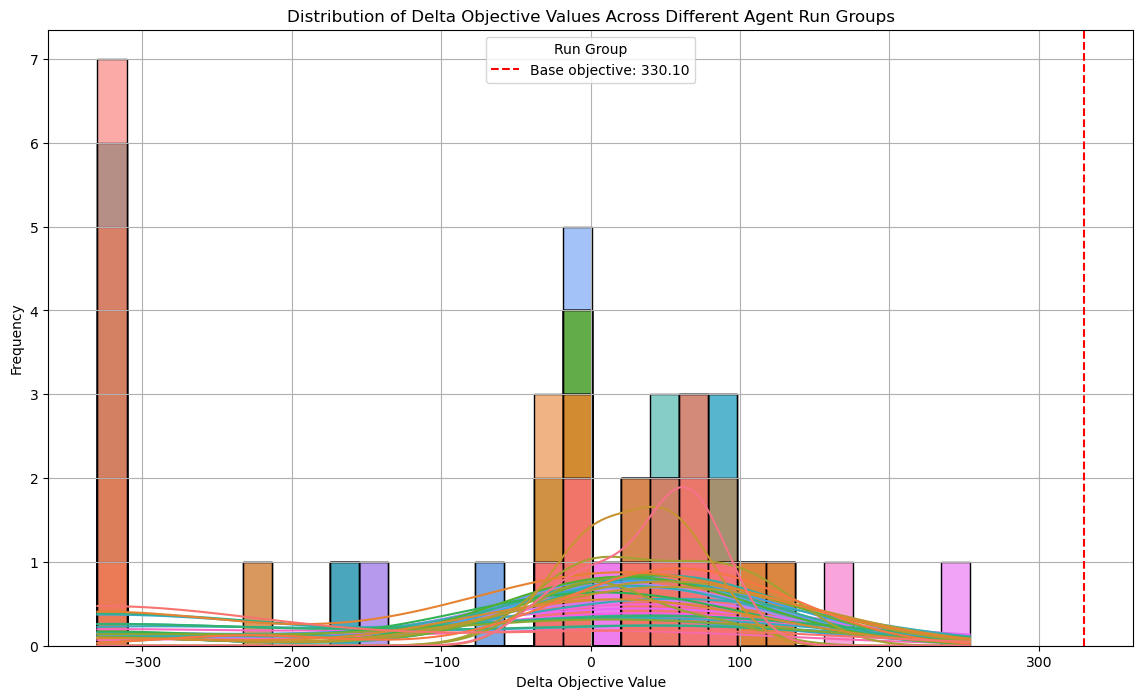

/tmp/ipykernel_13161/1110853651.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Run Group')


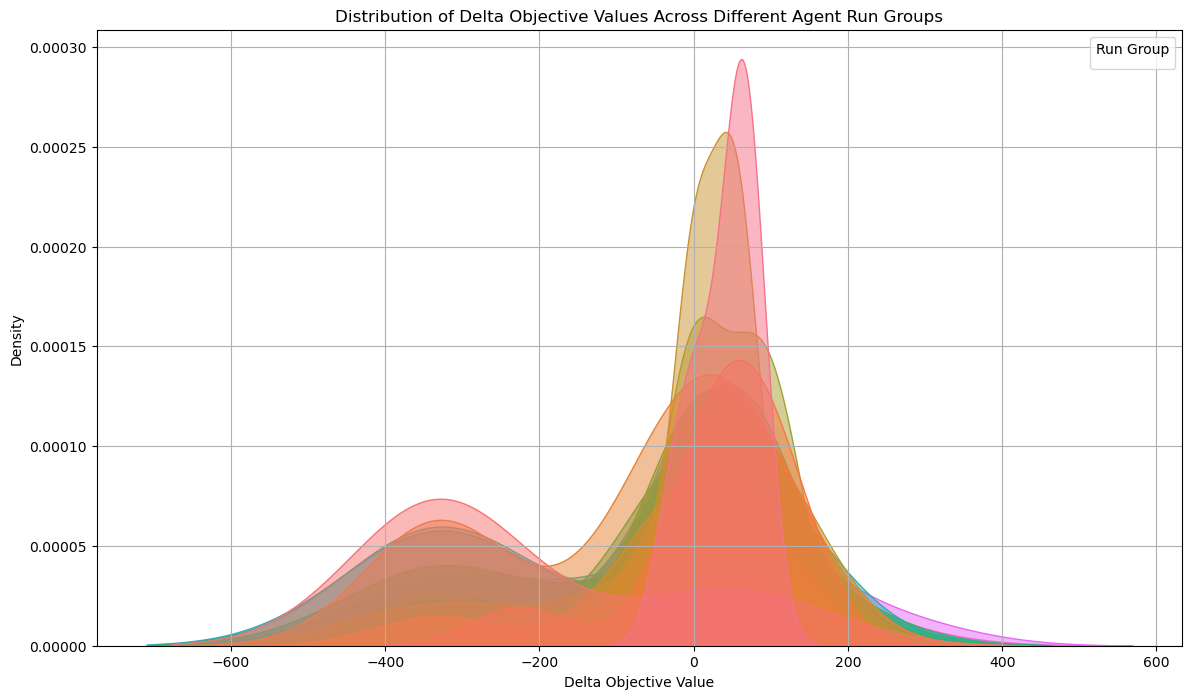

/tmp/ipykernel_13161/1110853651.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Run Group')


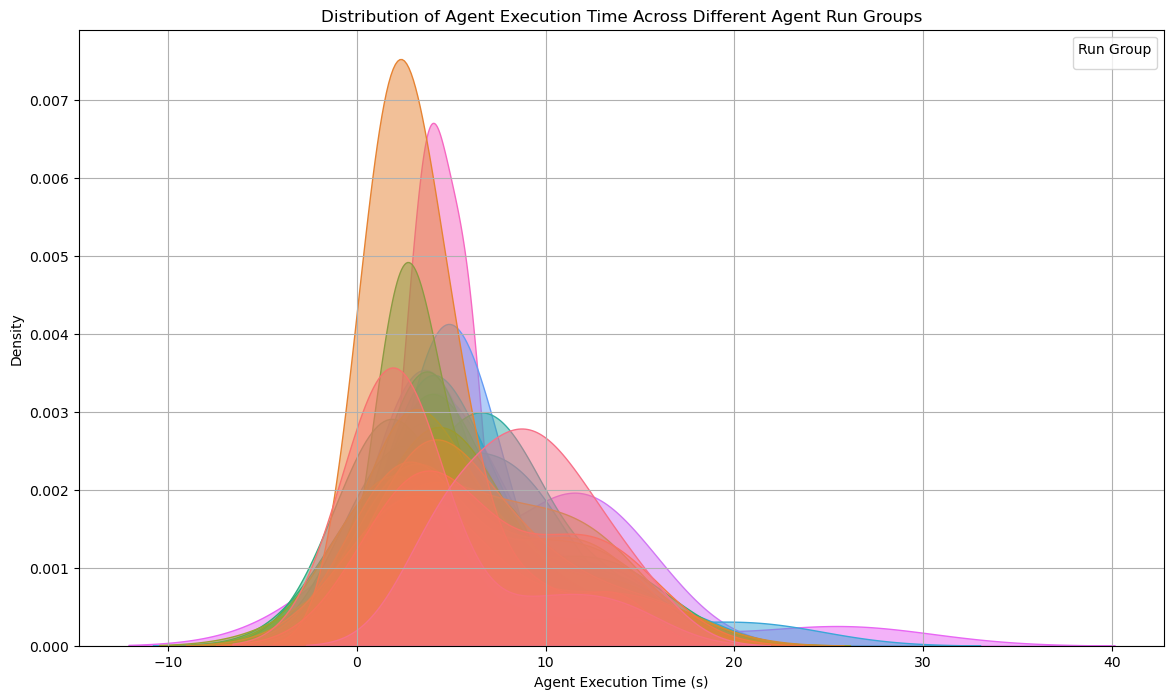

In [35]:
# Example: Distribution of Delta Objective Values by Run Group
plt.figure(figsize=(14, 8))
sns.histplot(data=df_all_agents, x='delta_obj', hue='run_group_label', kde=True, bins=30, alpha=0.6)
plt.axvline(baseline_obj_value, color='red', linestyle='--', label=f'Base objective: {baseline_obj_value:.2f}')
plt.title('Distribution of Delta Objective Values Across Different Agent Run Groups')
plt.xlabel('Delta Objective Value')
plt.ylabel('Frequency')
plt.legend(title='Run Group')
plt.grid(True)
plt.show()

# Example: Distribution of Delta Objective Values by Run Group
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df_all_agents, x='delta_obj', hue='run_group_label', fill=True, alpha=0.5)
plt.title('Distribution of Delta Objective Values Across Different Agent Run Groups')
plt.xlabel('Delta Objective Value')
plt.ylabel('Density')
plt.legend(title='Run Group')
plt.grid(True)
plt.show()

# Example: Distribution of Agent Execution Time by Run Group
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df_all_agents, x='agent_execution_time', hue='run_group_label', fill=True, alpha=0.5)
plt.title('Distribution of Agent Execution Time Across Different Agent Run Groups')
plt.xlabel('Agent Execution Time (s)')
plt.ylabel('Density')
plt.legend(title='Run Group')
plt.grid(True)
plt.show()

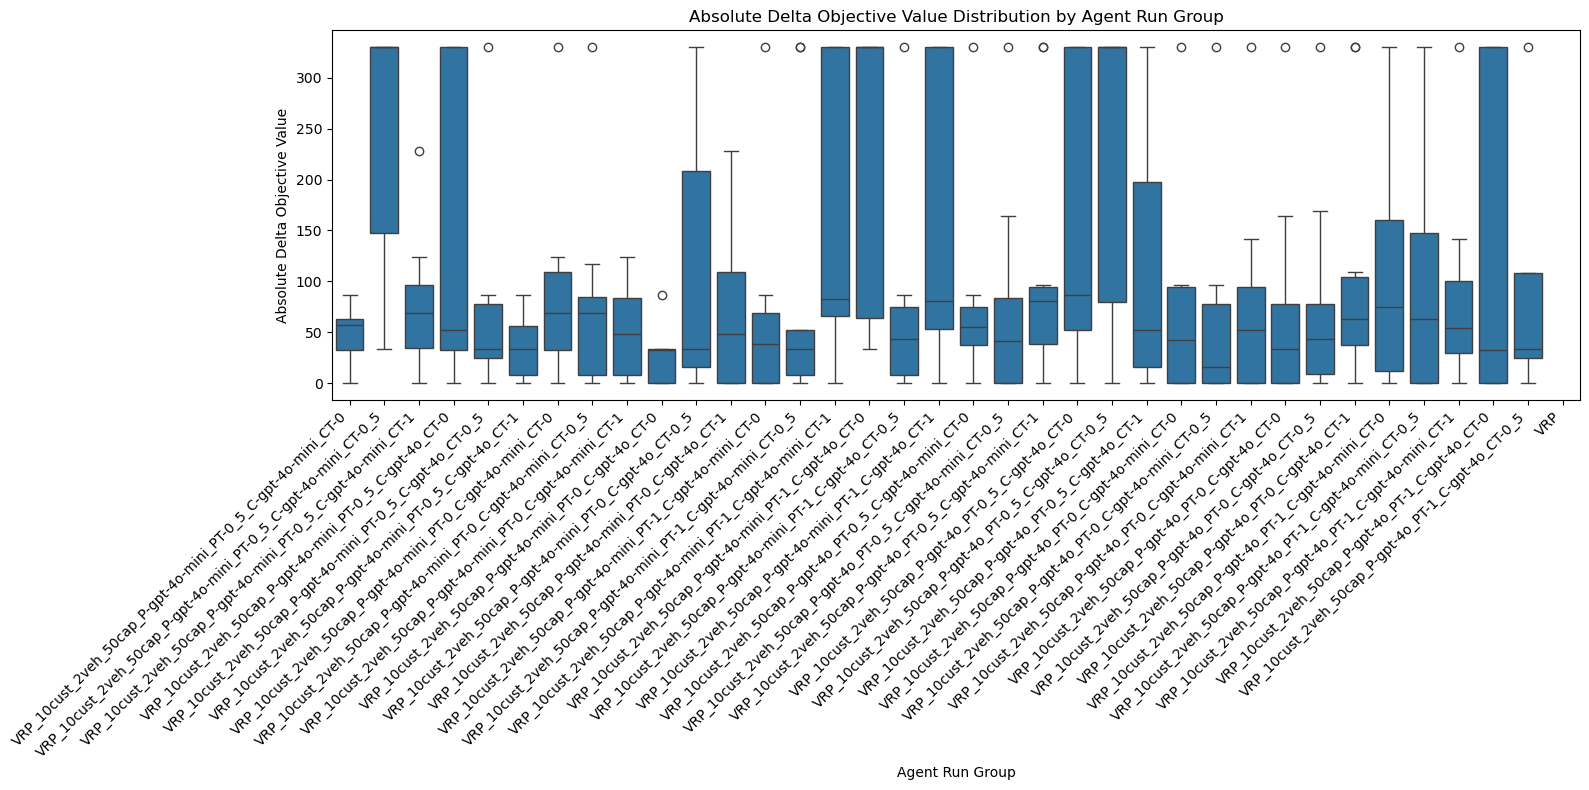

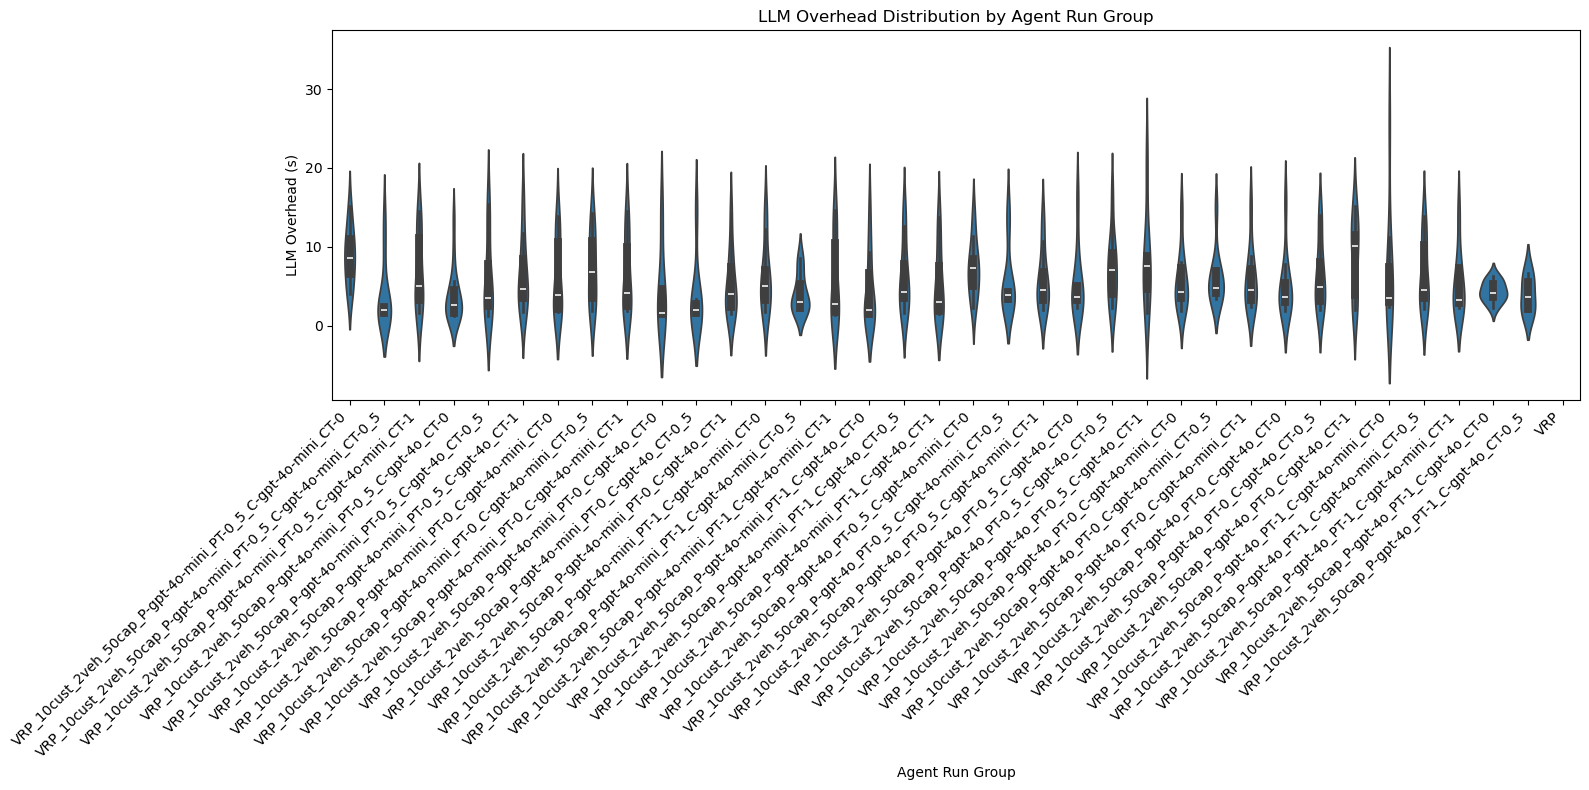

In [36]:
# Example: Box Plot of Absolute Delta Objective by Run Group
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_all_agents, x='run_group_label', y=df_all_agents['delta_obj'].abs())
plt.title('Absolute Delta Objective Value Distribution by Agent Run Group')
plt.xlabel('Agent Run Group')
plt.ylabel('Absolute Delta Objective Value')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()

df_all_agents['llm_overhead_sec'] = df_all_agents["agent_execution_time"] - df_all_agents["pulp_model_execution_time"]

# Example: Violin Plot of LLM Overhead by Run Group
plt.figure(figsize=(16, 8))
sns.violinplot(data=df_all_agents, x='run_group_label', y='llm_overhead_sec')
plt.title('LLM Overhead Distribution by Agent Run Group')
plt.xlabel('Agent Run Group')
plt.ylabel('LLM Overhead (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_13161/4248624961.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_runs = df_all_agents.groupby(['run_group_label', 'run_id']).apply(


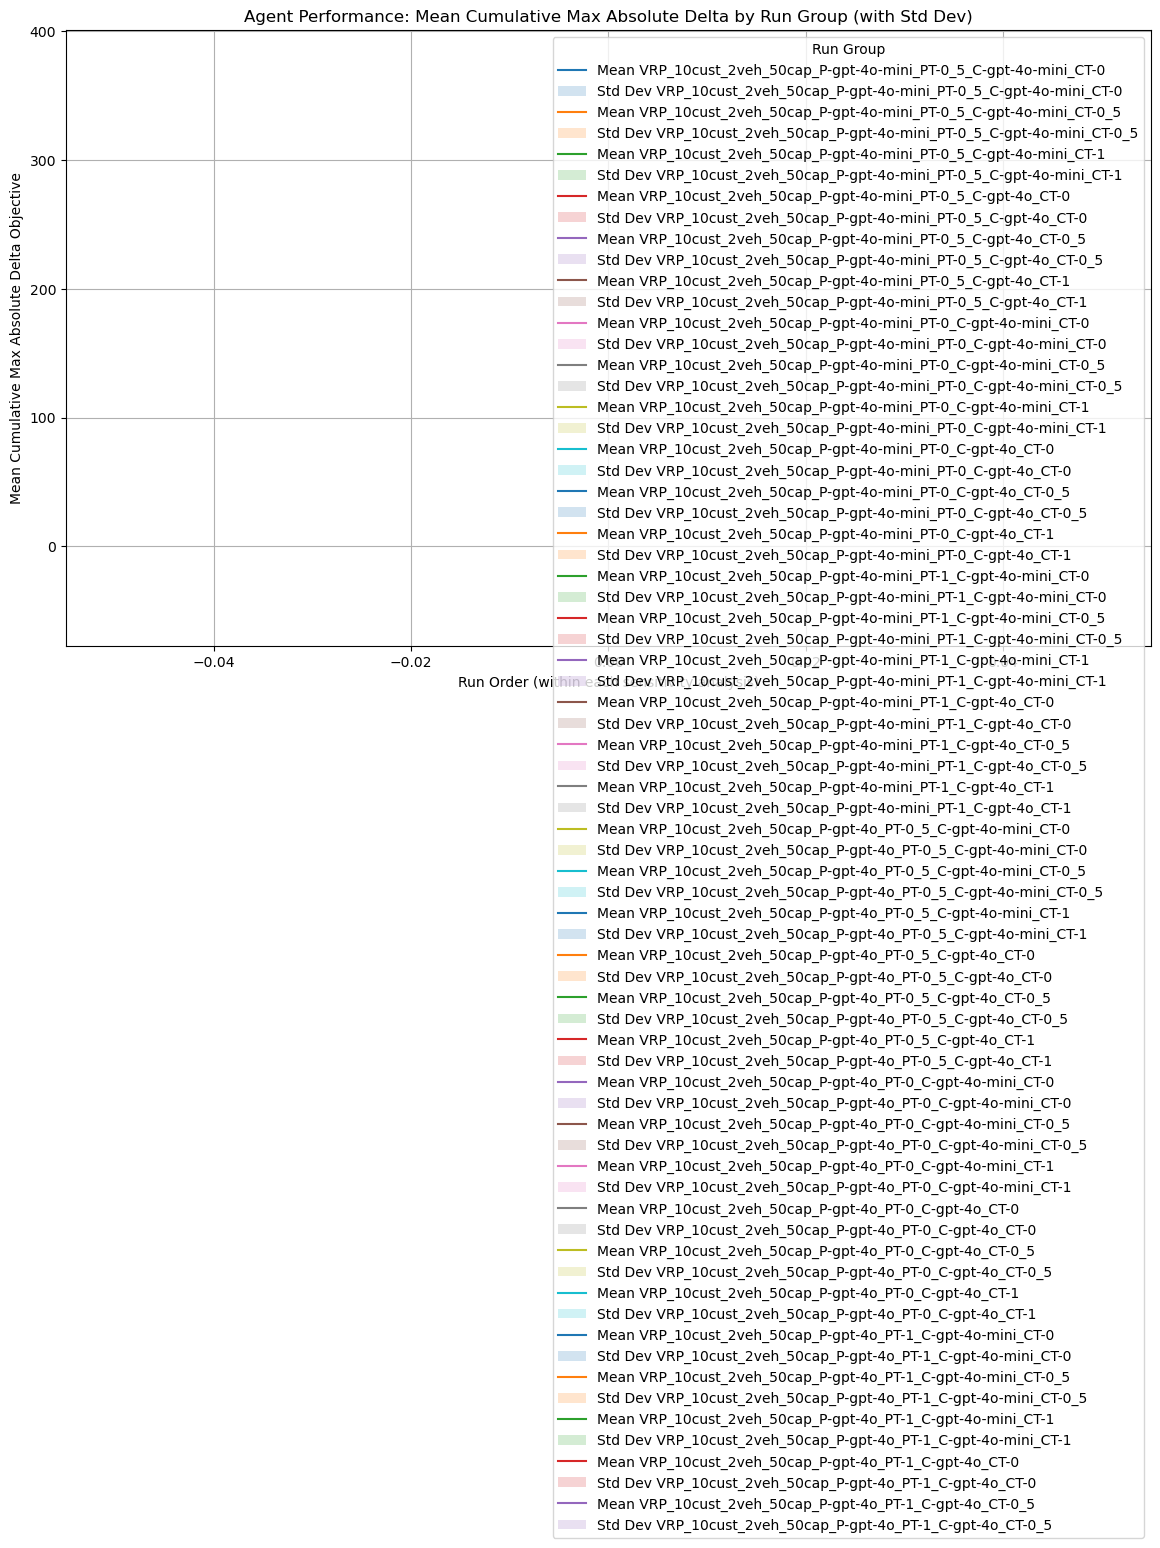

In [37]:
# This requires a more complex aggregation.
# First, calculate cumulative_max_abs_delta for each unique run_id within each group
df_all_agents['abs_delta_obj'] = df_all_agents['delta_obj'].abs()

# Group by run_group_label and run_id, then sort by timestamp to get individual run sequences
grouped_runs = df_all_agents.groupby(['run_group_label', 'run_id']).apply(
    lambda x: x.sort_values('timestamp').assign(
        cumulative_max_abs_delta_individual=x['abs_delta_obj'].expanding().max(),
        run_order=range(len(x)) # Assign a sequential order within each run
    )
).reset_index(drop=True)

# Now, aggregate these individual cumulative curves by run_group_label and run_order
summary_performance = grouped_runs.groupby(['run_group_label', 'run_order'])['cumulative_max_abs_delta_individual'].agg(
    mean_delta='mean',
    std_delta='std'
).reset_index()

plt.figure(figsize=(14, 8))
for group_name, group_data in summary_performance.groupby('run_group_label'):
    plt.plot(group_data['run_order'], group_data['mean_delta'], label=f'Mean {group_name}')
    plt.fill_between(
        group_data['run_order'],
        group_data['mean_delta'] - group_data['std_delta'],
        group_data['mean_delta'] + group_data['std_delta'],
        alpha=0.2, label=f'Std Dev {group_name}'
    )
plt.title('Agent Performance: Mean Cumulative Max Absolute Delta by Run Group (with Std Dev)')
plt.xlabel('Run Order (within each sensitivity analysis)')
plt.ylabel('Mean Cumulative Max Absolute Delta Objective')
plt.legend(title='Run Group')
plt.grid(True)
plt.show()

## Performance vs planner model

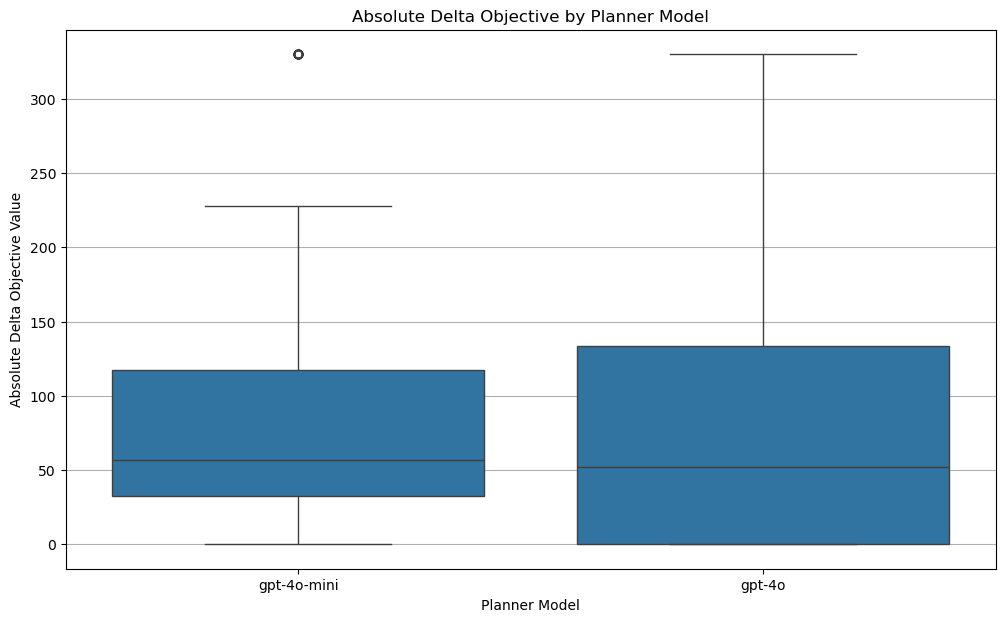

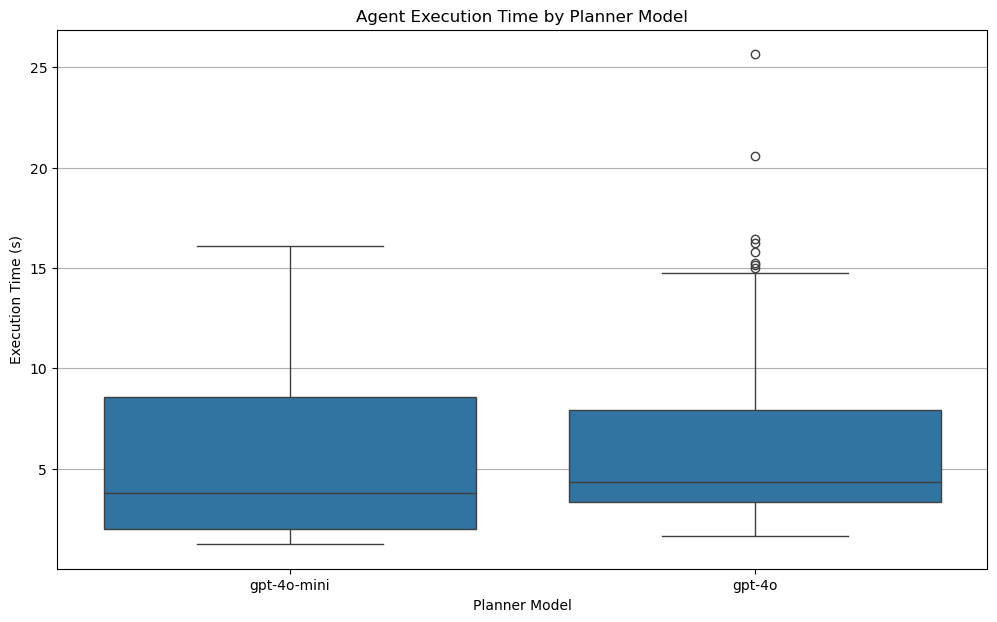

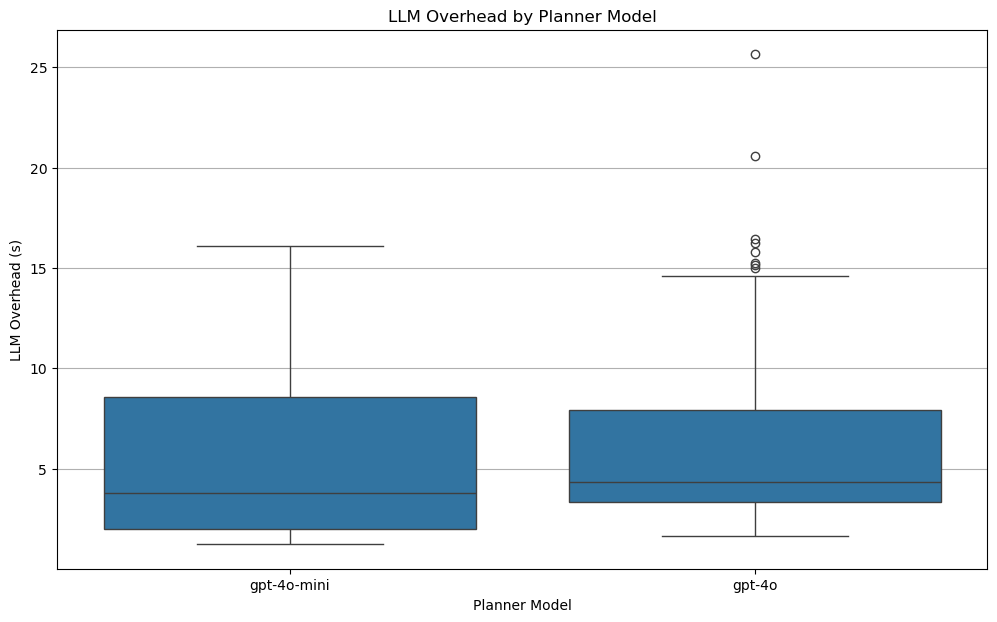

In [38]:
# Ensure 'abs_delta_obj' is available, or calculate it if not
if 'abs_delta_obj' not in df_all_agents.columns:
    df_all_agents['abs_delta_obj'] = df_all_agents['delta_obj'].abs()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_all_agents, x='planner_model', y='abs_delta_obj')
plt.title('Absolute Delta Objective by Planner Model')
plt.xlabel('Planner Model')
plt.ylabel('Absolute Delta Objective Value')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_all_agents, x='planner_model', y='agent_execution_time')
plt.title('Agent Execution Time by Planner Model')
plt.xlabel('Planner Model')
plt.ylabel('Execution Time (s)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_all_agents, x='planner_model', y='llm_overhead_sec')
plt.title('LLM Overhead by Planner Model')
plt.xlabel('Planner Model')
plt.ylabel('LLM Overhead (s)')
plt.grid(axis='y')
plt.show()


## Performance vs coder model

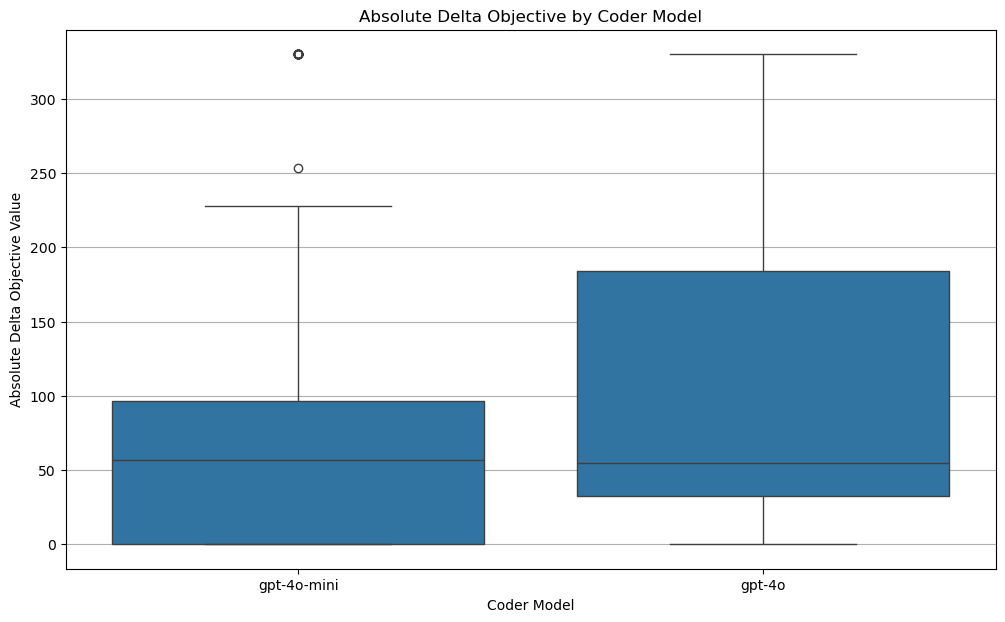

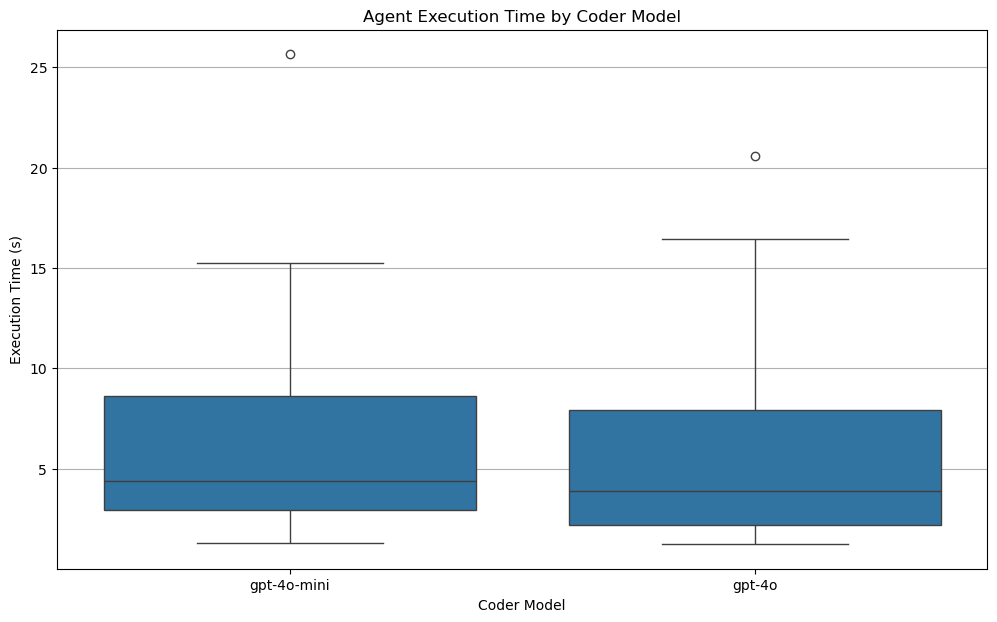

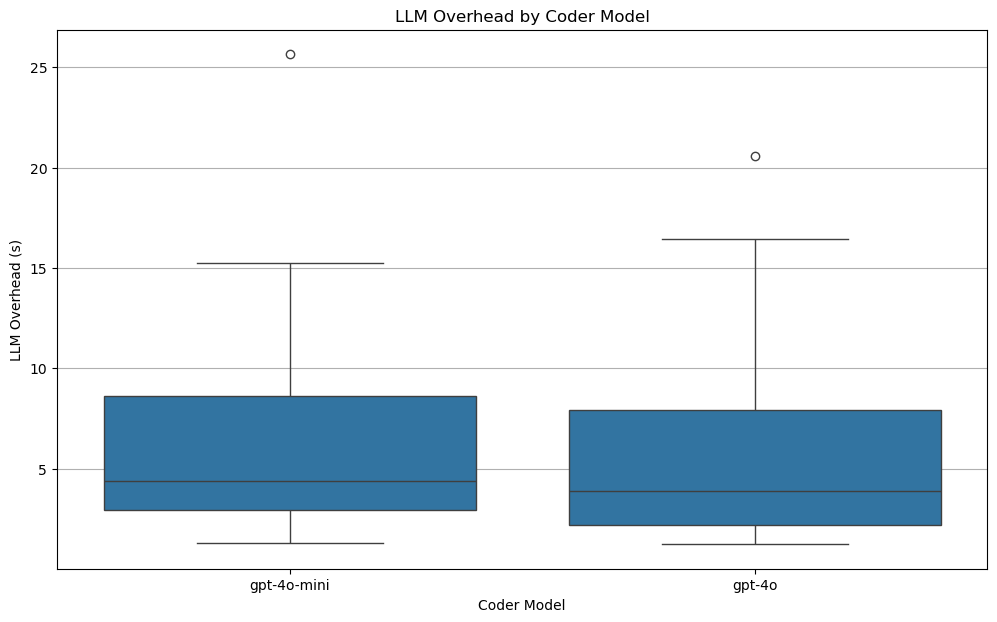

In [39]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_all_agents, x='coder_model', y='abs_delta_obj')
plt.title('Absolute Delta Objective by Coder Model')
plt.xlabel('Coder Model')
plt.ylabel('Absolute Delta Objective Value')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_all_agents, x='coder_model', y='agent_execution_time')
plt.title('Agent Execution Time by Coder Model')
plt.xlabel('Coder Model')
plt.ylabel('Execution Time (s)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_all_agents, x='coder_model', y='llm_overhead_sec')
plt.title('LLM Overhead by Coder Model')
plt.xlabel('Coder Model')
plt.ylabel('LLM Overhead (s)')
plt.grid(axis='y')
plt.show()


# Performance versus planner temperature

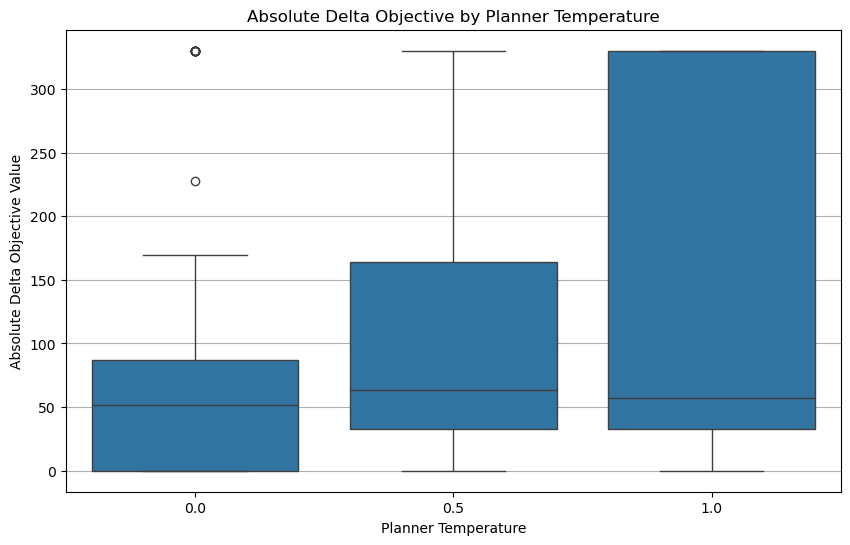

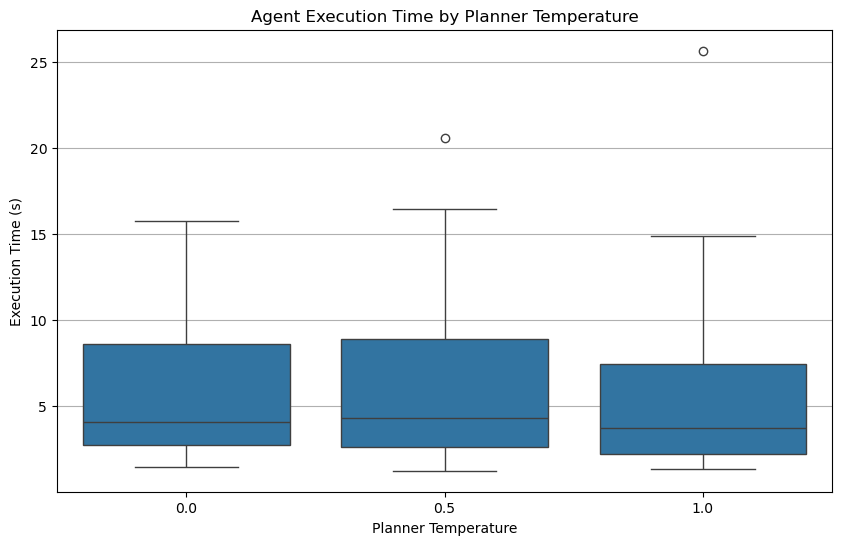

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_agents, x='planner_temperature', y='abs_delta_obj')
plt.title('Absolute Delta Objective by Planner Temperature')
plt.xlabel('Planner Temperature')
plt.ylabel('Absolute Delta Objective Value')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_agents, x='planner_temperature', y='agent_execution_time')
plt.title('Agent Execution Time by Planner Temperature')
plt.xlabel('Planner Temperature')
plt.ylabel('Execution Time (s)')
plt.grid(axis='y')
plt.show()


## Performance vs. Coder Temperature


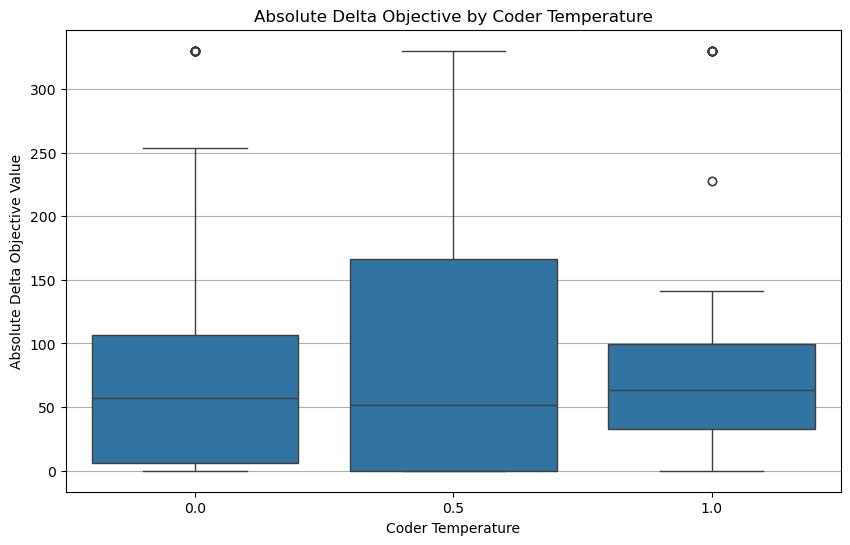

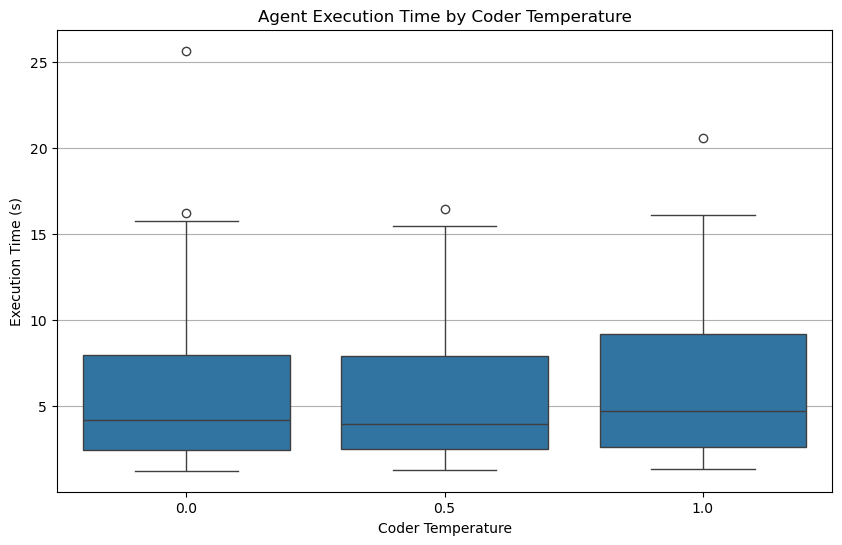

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_agents, x='coder_temperature', y='abs_delta_obj')
plt.title('Absolute Delta Objective by Coder Temperature')
plt.xlabel('Coder Temperature')
plt.ylabel('Absolute Delta Objective Value')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_agents, x='coder_temperature', y='agent_execution_time')
plt.title('Agent Execution Time by Coder Temperature')
plt.xlabel('Coder Temperature')
plt.ylabel('Execution Time (s)')
plt.grid(axis='y')
plt.show()


## Interaction between Planner and Coder Temperatures


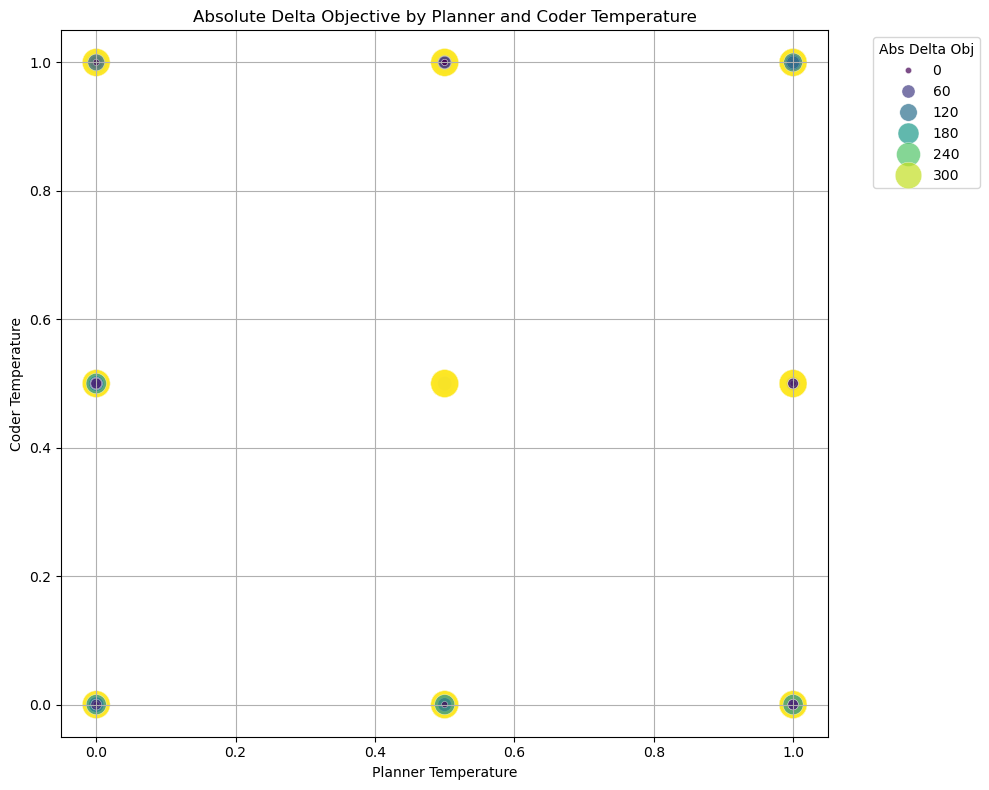

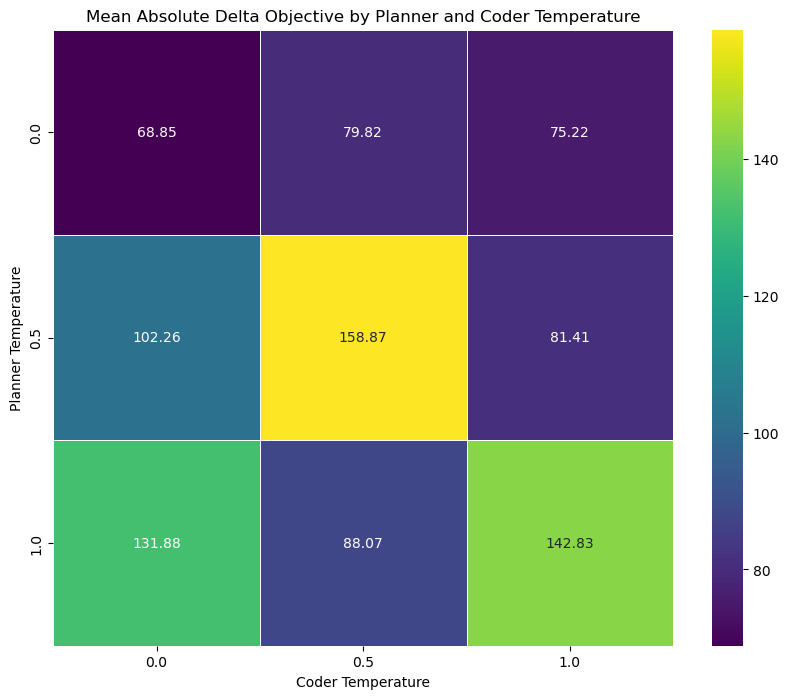

In [42]:
# Scatter plot showing interaction
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_all_agents,
    x='planner_temperature',
    y='coder_temperature',
    hue='abs_delta_obj', # Color points by absolute delta objective
    size='abs_delta_obj', # Size points by absolute delta objective
    sizes=(20, 400), # Range of sizes for points
    palette='viridis', # Color palette
    alpha=0.7
)
plt.title('Absolute Delta Objective by Planner and Coder Temperature')
plt.xlabel('Planner Temperature')
plt.ylabel('Coder Temperature')
plt.grid(True)
plt.legend(title='Abs Delta Obj', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Alternatively, a heatmap of mean absolute delta objective for each combination
# First, calculate the mean abs_delta_obj for each unique combination
pivot_table = df_all_agents.pivot_table(
    values='abs_delta_obj',
    index='planner_temperature',
    columns='coder_temperature',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Mean Absolute Delta Objective by Planner and Coder Temperature')
plt.xlabel('Coder Temperature')
plt.ylabel('Planner Temperature')
plt.show()


# PuLP Status Distribution by Planner Model

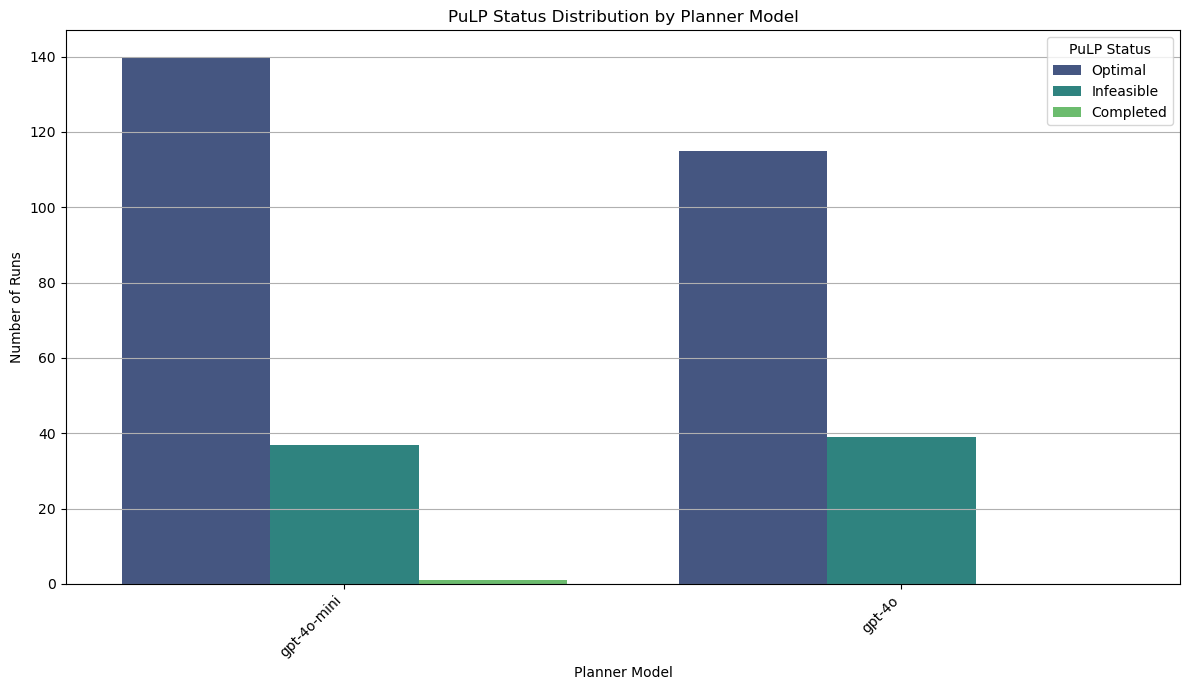

In [43]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df_all_agents, x='planner_model', hue='status', palette='viridis')
plt.title('PuLP Status Distribution by Planner Model')
plt.xlabel('Planner Model')
plt.ylabel('Number of Runs')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PuLP Status')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## PuLP Status Distribution by Coder Model


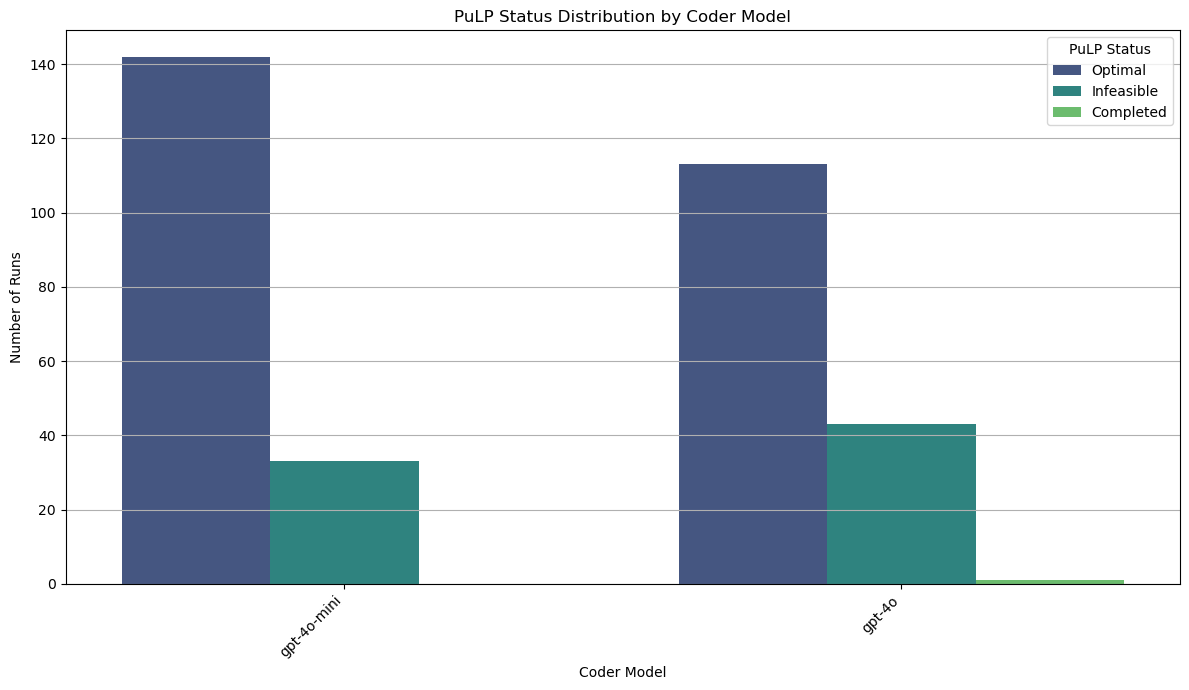

In [44]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df_all_agents, x='coder_model', hue='status', palette='viridis')
plt.title('PuLP Status Distribution by Coder Model')
plt.xlabel('Coder Model')
plt.ylabel('Number of Runs')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PuLP Status')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## PuLP Status Distribution by Planner Temperature


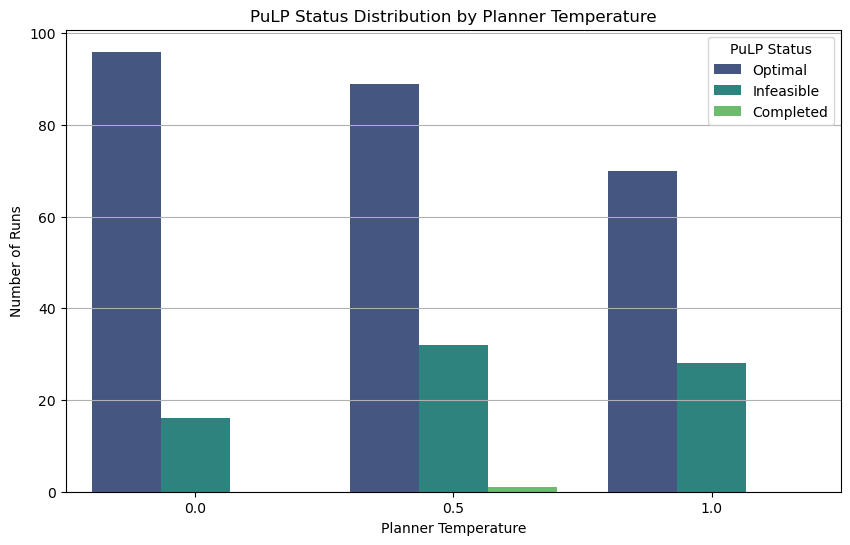

In [45]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_agents, x='planner_temperature', hue='status', palette='viridis')
plt.title('PuLP Status Distribution by Planner Temperature')
plt.xlabel('Planner Temperature')
plt.ylabel('Number of Runs')
plt.legend(title='PuLP Status')
plt.grid(axis='y')
plt.show()


## PuLP Status Distribution by Coder Temperature


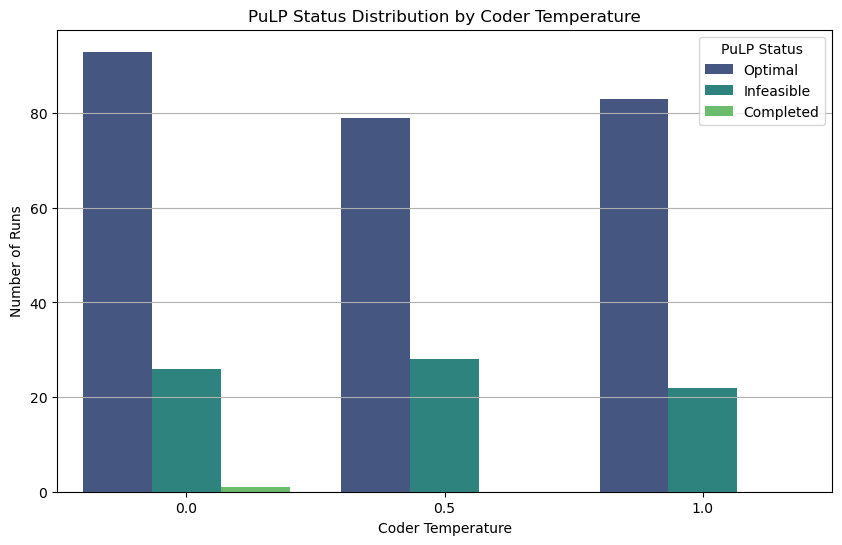

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_agents, x='coder_temperature', hue='status', palette='viridis')
plt.title('PuLP Status Distribution by Coder Temperature')
plt.xlabel('Coder Temperature')
plt.ylabel('Number of Runs')
plt.legend(title='PuLP Status')
plt.grid(axis='y')
plt.show()


## Percentage of Optimal Solutions by Temperature Combinations (Heatmap)


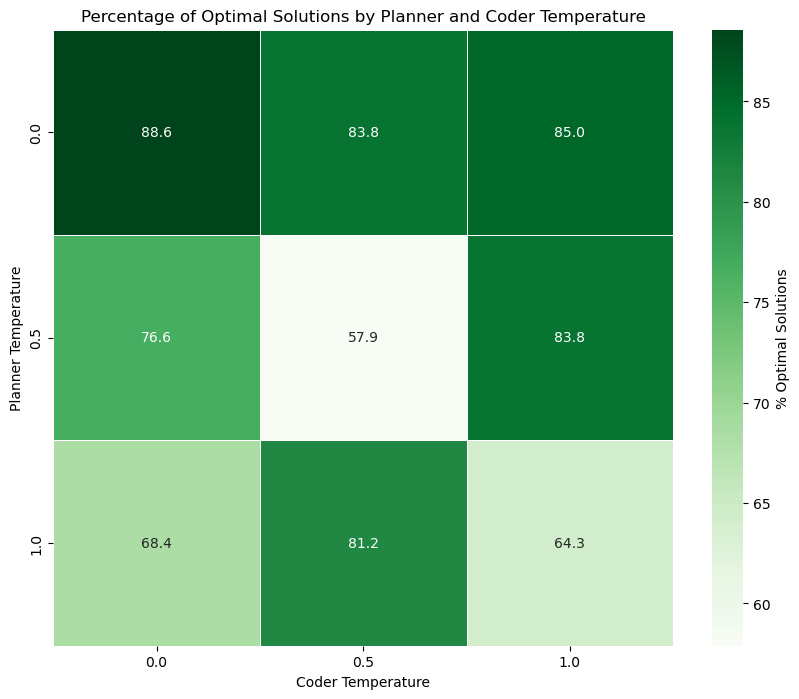

In [47]:
# Calculate the percentage of 'Optimal' solutions for each combination of temperatures
status_counts = df_all_agents.groupby(['planner_temperature', 'coder_temperature', 'status']).size().unstack(fill_value=0)
status_percentages = status_counts.apply(lambda x: x / x.sum() * 100, axis=1)

# Ensure 'Optimal' column exists, fill with 0 if not
if 'Optimal' not in status_percentages.columns:
    status_percentages['Optimal'] = 0

optimal_percentage_pivot = status_percentages['Optimal'].unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(optimal_percentage_pivot, annot=True, fmt=".1f", cmap="Greens", linewidths=.5, cbar_kws={'label': '% Optimal Solutions'})
plt.title('Percentage of Optimal Solutions by Planner and Coder Temperature')
plt.xlabel('Coder Temperature')
plt.ylabel('Planner Temperature')
plt.show()


## Tables

In [48]:
# --- Constants ---
NUM_ITERATIONS_PER_RUN = 20 # As per your table caption

# --- Parse token_usage JSON and Extract Metrics ---
# Ensure 'token_usage' column exists and is not NaN before applying json.loads
df_all_agents['token_dict'] = df_all_agents['token_usage'].apply(
    lambda x: json.loads(x) if pd.notna(x) else {}
)

# Extract planner and coder token counts and costs
df_all_agents['planner_total_tokens']    = df_all_agents['token_dict'].apply(lambda d: d.get('planner', {}).get('total', 0))
df_all_agents['planner_prompt_tokens']   = df_all_agents['token_dict'].apply(lambda d: d.get('planner', {}).get('prompt', 0))
df_all_agents['planner_completion_tokens'] = df_all_agents['token_dict'].apply(lambda d: d.get('planner', {}).get('completion', 0))
df_all_agents['planner_total_cost']    = df_all_agents['token_dict'].apply(lambda d: d.get('planner', {}).get('total_cost', 0))

df_all_agents['coder_total_tokens']      = df_all_agents['token_dict'].apply(lambda d: d.get('coder', {}).get('total', 0))
df_all_agents['coder_prompt_tokens']     = df_all_agents['token_dict'].apply(lambda d: d.get('coder', {}).get('prompt', 0))
df_all_agents['coder_completion_tokens'] = df_all_agents['token_dict'].apply(lambda d: d.get('coder', {}).get('completion', 0))
df_all_agents['coder_total_cost']    = df_all_agents['token_dict'].apply(lambda d: d.get('coder', {}).get('total_cost', 0))

# --- Data Preparation and Aggregation ---

# Filter out GPT-4.1 models as requested
df_filtered = df_all_agents[
    (~df_all_agents['planner_model'].str.contains('gpt-4.1', na=False)) &
    (~df_all_agents['coder_model'].str.contains('gpt-4.1', na=False))
].copy()

# --- Planner Agent Statistics ---
# Group by planner model and temperature, then calculate means of the extracted token/cost columns
planner_stats = df_filtered.groupby(['planner_model', 'planner_temperature']).agg(
    avg_prompt_tokens=('planner_prompt_tokens', 'mean'),
    avg_completion_tokens=('planner_completion_tokens', 'mean'),
    avg_total_tokens=('planner_total_tokens', 'mean'),
    avg_total_cost_per_call=('planner_total_cost', 'mean')
).reset_index()

planner_results = []
for _, row in planner_stats.iterrows():
    model = row['planner_model']
    temp = row['planner_temperature']
    avg_prompt = row['avg_prompt_tokens']
    avg_compl = row['avg_completion_tokens']
    avg_total = row['avg_total_tokens']
    avg_cost_per_call = row['avg_total_cost_per_call']

    # Estimated cost per run (Avg Cost per Call * Number of Iterations)
    est_cost_per_run = avg_cost_per_call * NUM_ITERATIONS_PER_RUN

    planner_results.append({
        'Agent Role': 'Planner Agent',
        'LLM Model': model,
        'Temp.': temp,
        'Avg. Prompt Tokens/Call': avg_prompt,
        'Avg. Compl. Tokens/Call': avg_compl,
        'Avg. Total Tokens/Call': avg_total,
        'Est. Cost per Run (USD)': est_cost_per_run
    })

# --- Coder Agent Statistics ---
# Group by coder model and temperature, then calculate means of the extracted token/cost columns
coder_stats = df_filtered.groupby(['coder_model', 'coder_temperature']).agg(
    avg_prompt_tokens=('coder_prompt_tokens', 'mean'),
    avg_completion_tokens=('coder_completion_tokens', 'mean'),
    avg_total_tokens=('coder_total_tokens', 'mean'),
    avg_total_cost_per_call=('coder_total_cost', 'mean')
).reset_index()

coder_results = []
for _, row in coder_stats.iterrows():
    model = row['coder_model']
    temp = row['coder_temperature']
    avg_prompt = row['avg_prompt_tokens']
    avg_compl = row['avg_completion_tokens']
    avg_total = row['avg_total_tokens']
    avg_cost_per_call = row['avg_total_cost_per_call']

    est_cost_per_run = avg_cost_per_call * NUM_ITERATIONS_PER_RUN

    coder_results.append({
        'Agent Role': 'Coder Agent',
        'LLM Model': model,
        'Temp.': temp,
        'Avg. Prompt Tokens/Call': avg_prompt,
        'Avg. Compl. Tokens/Call': avg_compl,
        'Avg. Total Tokens/Call': avg_total,
        'Est. Cost per Run (USD)': est_cost_per_run
    })

# Combine results for table generation
all_agent_results = pd.DataFrame(planner_results + coder_results)

# Sort for consistent output
all_agent_results = all_agent_results.sort_values(by=['Agent Role', 'LLM Model', 'Temp.'])

# --- Generate LaTeX Table ---
latex_table_string = """
\\begin{table}[H] % Or [htbp]
\\centering
\\caption{Average LLM Token Usage and Estimated API Costs for a 20-Iteration VRP Run (10c/2v/50c) under Different Agent Configurations.}
\\label{tab:res_token_usage_summary}
\\small
\\begin{tabular}{@{}lrrrrrr@{}}
\\toprule
\\textbf{Agent Role} & \\textbf{LLM Model} & \\textbf{Temp.} & \\textbf{Avg. Prompt} & \\textbf{Avg. Compl.} & \\textbf{Avg. Total} & \\textbf{Est. Cost} \\\\
                    &                    &                & \\textbf{Tokens/Call} & \\textbf{Tokens/Call} & \\textbf{Tokens/Call} & \\textbf{per Run (USD)} \\\\
\\midrule
"""

current_role = None
for index, row in all_agent_results.iterrows():
    if row['Agent Role'] != current_role:
        if current_role is not None:
            latex_table_string += "\\addlinespace\n"
        latex_table_string += f"\\textit{{{row['Agent Role']}}} & & & & & & \\\\\n"
        current_role = row['Agent Role']

    latex_table_string += (
        f"& \\texttt{{{row['LLM Model']}}} & {row['Temp.']:.1f} & "
        f"\\texttt{{{row['Avg. Prompt Tokens/Call']:.0f}}} & "
        f"\\texttt{{{row['Avg. Compl. Tokens/Call']:.0f}}} & "
        f"\\texttt{{{row['Avg. Total Tokens/Call']:.0f}}} & "
        f"\\texttt{{{row['Est. Cost per Run (USD)']:.4f}}} \\\\\n"
    )

# Final Summary Agent placeholder (still omitted as per previous discussion)
# If you have data for it, we can add it here.

latex_table_string += """
\\bottomrule
\\end{tabular}
\\end{table}
"""

print(latex_table_string)

# --- Example text for thesis (you'll need to fill in actual values from the generated table) ---
thesis_text_template = """
As indicated in Table \\ref{tab:res_token_usage_summary}, the choice of LLM significantly impacts token consumption. Generally, more capable models like \\texttt{gpt-4o} tended to use [more/less/comparable] prompt tokens for similar tasks compared to their 'mini' counterparts, possibly due to different internal processing or context handling, and their completion lengths also varied. For instance, the Planner agent using \\texttt{{[Model A]}} averaged \\texttt{{[P_Val_Tokens_A]}} total tokens per scenario proposal, while using \\texttt{{[Model B]}} averaged \\texttt{{[P_Val_Tokens_B]}} tokens. Similarly, the Coder agent's token usage for generating JSON modifications showed variations, with \\texttt{{[Model C]}} averaging \\texttt{{[C_Val_Tokens_C]}} tokens per translation compared to \\texttt{{[Model D]}} at \\texttt{{[C_Val_Tokens_D]}} tokens.

The temperature setting appeared to have a [minor/moderate/significant] effect on completion token length for the Planner, with higher temperatures sometimes leading to [more verbose/more concise/no clear trend] scenario proposals. For the Coder, where low temperatures were consistently used to promote accuracy, the completion lengths were generally more stable for a given model.

The estimated API costs, derived from the token counts and OpenAI's pricing models at the time of experimentation, reflect these usage patterns. The total cost for a 20-iteration sensitivity analysis run, combining Planner and Coder usage, ranged from approximately \\texttt{{[Min_Total_Cost_USD]}} to \\texttt{{[Max_Total_Cost_USD]}} for the VRP instance, depending on the LLM configuration. The use of newer models like the GPT-4.1 series, which were noted for more favorable pricing, generally resulted in [lower/comparable] overall costs for similar or improved performance levels, as will be further discussed in the context of quality metrics. These findings underscore the importance of model selection not only for performance but also for the economic viability of deploying LLM-driven agent systems.
"""
# print(thesis_text_template)



\begin{table}[H] % Or [htbp]
\centering
\caption{Average LLM Token Usage and Estimated API Costs for a 20-Iteration VRP Run (10c/2v/50c) under Different Agent Configurations.}
\label{tab:res_token_usage_summary}
\small
\begin{tabular}{@{}lrrrrrr@{}}
\toprule
\textbf{Agent Role} & \textbf{LLM Model} & \textbf{Temp.} & \textbf{Avg. Prompt} & \textbf{Avg. Compl.} & \textbf{Avg. Total} & \textbf{Est. Cost} \\
                    &                    &                & \textbf{Tokens/Call} & \textbf{Tokens/Call} & \textbf{Tokens/Call} & \textbf{per Run (USD)} \\
\midrule
\textit{Coder Agent} & & & & & & \\
& \texttt{gpt-4o} & 0.0 & \texttt{2768} & \texttt{29} & \texttt{2797} & \texttt{0.0814} \\
& \texttt{gpt-4o} & 0.5 & \texttt{2815} & \texttt{26} & \texttt{2842} & \texttt{0.0789} \\
& \texttt{gpt-4o} & 1.0 & \texttt{2814} & \texttt{26} & \texttt{2840} & \texttt{0.0802} \\
& \texttt{gpt-4o-mini} & 0.0 & \texttt{2813} & \texttt{25} & \texttt{2839} & \texttt{0.0050} \\
& \texttt{gpt-4o-mini

In [49]:
all_agent_results.head()

,Agent Role,LLM Model,Temp.,Avg. Prompt Tokens/Call,Avg. Compl. Tokens/Call,Avg. Total Tokens/Call,Est. Cost per Run (USD)
6,Coder Agent,gpt-4o,0.0,2767.983607,28.770492,2796.754098,0.081360
7,Coder Agent,gpt-4o,0.5,2815.306122,26.469388,2841.775510,0.078859
8,Coder Agent,gpt-4o,1.0,2814.063830,26.106383,2840.170213,0.080154
9,Coder Agent,gpt-4o-mini,0.0,2813.440678,25.491525,2838.932203,0.004988
10,Coder Agent,gpt-4o-mini,0.5,2813.620690,25.931034,2839.551724,0.005068


## Top K Coverage


Top 10 Benchmark Scenarios (Absolute Delta Objective Range):
Min Abs Delta: 85.8400, Max Abs Delta: 105.0800

--- Top K Coverage Summary per Agent Run Group ---
                                      run_group_label  total_runs  \
0   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-g...          10   
1   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-g...          10   
2   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-g...          10   
3   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-g...          17   
4   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-g...           8   
5   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-g...          10   
6   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_C-gpt...          10   
7   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_C-gpt...          10   
8   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_C-gpt...          10   
9   VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_C-gpt...           5   
10  VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_C-gpt...           7   
11  VRP_10

/tmp/ipykernel_13161/2829365755.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_k_summary, x='run_group_label', y='percentage_top_k_covered', palette='viridis')


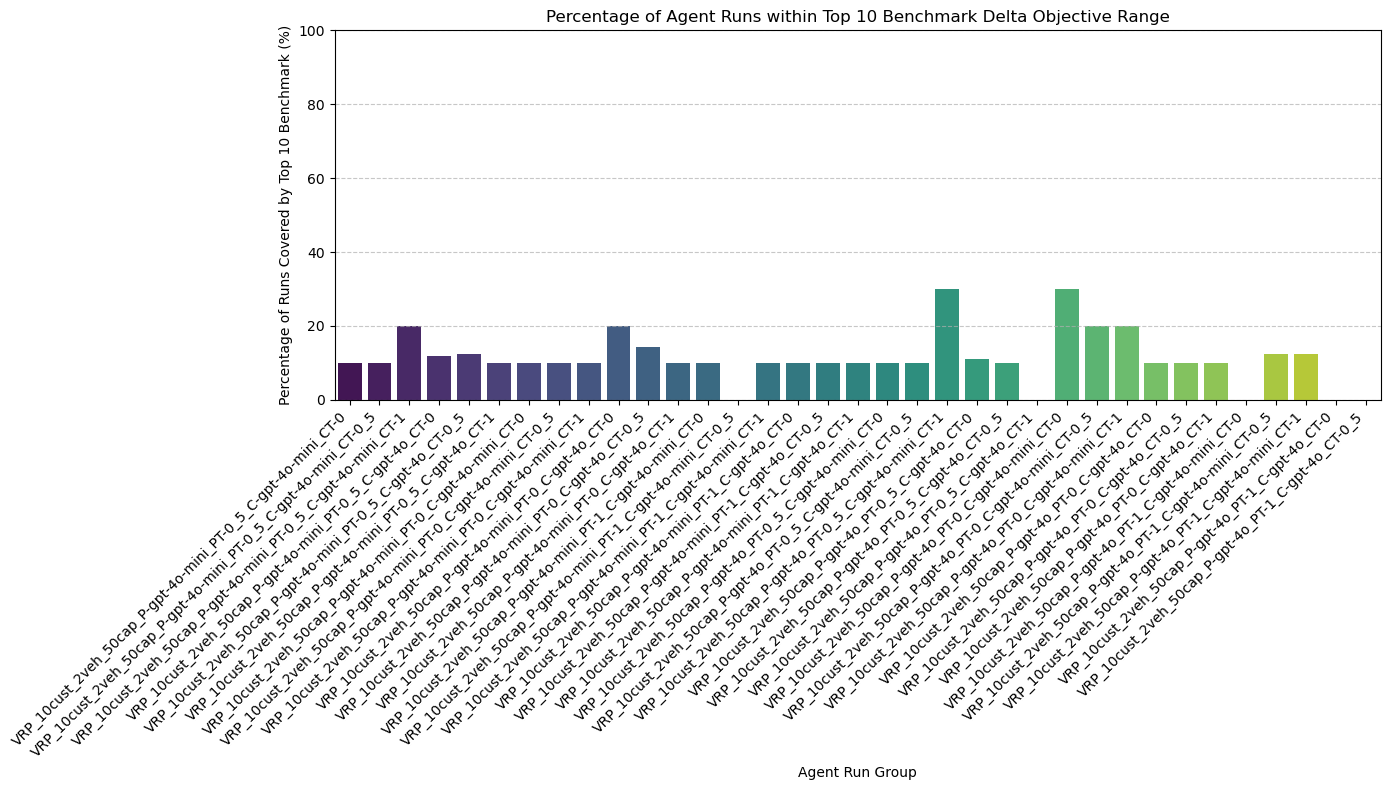


--- LaTeX Table for Top K Coverage ---

\begin{table}[H]
\centering
\caption{Percentage of Agent Runs within Top 10 Benchmark Absolute Delta Objective Range.}
\label{tab:top_k_coverage}
\small
\begin{tabular}{@{}lrrr@{}}
\toprule
\textbf{Agent Run Group} & \textbf{Total Runs} & \textbf{Top 10 Covered Runs} & \textbf{\% Covered} \\
\midrule
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o-mini_CT-0} & 10 & 1 & 10.00\% \\
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o-mini_CT-0_5} & 10 & 1 & 10.00\% \\
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o-mini_CT-1} & 10 & 2 & 20.00\% \\
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-0} & 17 & 2 & 11.76\% \\
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-0_5} & 8 & 1 & 12.50\% \\
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_5_C-gpt-4o_CT-1} & 10 & 1 & 10.00\% \\
\texttt{VRP_10cust_2veh_50cap_P-gpt-4o-mini_PT-0_C-gpt-4o-mini_CT-0} & 10 & 1 & 10.00\% \\
\texttt{VRP_10cust_2

In [50]:
# Ensure 'abs_delta_obj' is available in df_all_agents
if 'abs_delta_obj' not in df_all_agents.columns:
    df_all_agents['abs_delta_obj'] = df_all_agents['delta_obj'].abs()

# --- 1. Calculate Top K Benchmark Range ---
K_coverage = 10 # Define K for top scenarios, as per your example

# Get the top K benchmark scenarios by absolute delta_obj
# Assuming df_benchmark has 'delta_obj' column
top_k_benchmark_deltas = df_benchmark.sort_values(by='delta_obj', key=abs, ascending=False).head(K_coverage)

# Get the range of delta_obj values for these top K scenarios
min_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().min()
max_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().max()

print(f"\nTop {K_coverage} Benchmark Scenarios (Absolute Delta Objective Range):")
print(f"Min Abs Delta: {min_top_k_abs_delta:.4f}, Max Abs Delta: {max_top_k_abs_delta:.4f}")

# --- 2. Determine Best Performance per Agent Run ---
# Group by run_group_label and run_id to get the best (minimum) abs_delta_obj for each individual run
best_abs_delta_per_run = df_all_agents.groupby(['run_group_label', 'run_id'])['abs_delta_obj'].min().reset_index()
best_abs_delta_per_run.rename(columns={'abs_delta_obj': 'best_abs_delta_obj'}, inplace=True)

# --- 3. Categorize Agent Runs ---
best_abs_delta_per_run['is_top_k_covered'] = best_abs_delta_per_run['best_abs_delta_obj'].apply(
    lambda x: (x >= min_top_k_abs_delta) and (x <= max_top_k_abs_delta)
)

# --- 4. Aggregate by run_group_label ---
top_k_summary = best_abs_delta_per_run.groupby('run_group_label').agg(
    total_runs=('run_id', 'count'),
    top_k_covered_runs=('is_top_k_covered', lambda x: x.sum()) # Count True values
).reset_index()

top_k_summary['percentage_top_k_covered'] = (top_k_summary['top_k_covered_runs'] / top_k_summary['total_runs']) * 100

print("\n--- Top K Coverage Summary per Agent Run Group ---")
print(top_k_summary)

# --- 5. Visualize Results (Bar Chart) ---
plt.figure(figsize=(14, 8))
sns.barplot(data=top_k_summary, x='run_group_label', y='percentage_top_k_covered', palette='viridis')
plt.title(f'Percentage of Agent Runs within Top {K_coverage} Benchmark Delta Objective Range')
plt.xlabel('Agent Run Group')
plt.ylabel(f'Percentage of Runs Covered by Top {K_coverage} Benchmark (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # Ensure y-axis goes from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Optional: Generate LaTeX Table for Top K Summary ---
latex_table_string_top_k = """
\\begin{{table}}[H]
\\centering
\\caption{{Percentage of Agent Runs within Top {K_coverage} Benchmark Absolute Delta Objective Range.}}
\\label{{tab:top_k_coverage}}
\\small
\\begin{{tabular}}{{@{{}}lrrr@{{}}}}
\\toprule
\\textbf{{Agent Run Group}} & \\textbf{{Total Runs}} & \\textbf{{Top {K_coverage} Covered Runs}} & \\textbf{{\\% Covered}} \\\\
\\midrule
""".format(K_coverage=K_coverage)

for index, row in top_k_summary.iterrows():
    latex_table_string_top_k += (
        f"\\texttt{{{row['run_group_label']}}} & "
        f"{row['total_runs']:.0f} & "
        f"{row['top_k_covered_runs']:.0f} & "
        f"{row['percentage_top_k_covered']:.2f}\\% \\\\\n"
    )

latex_table_string_top_k += """
\\bottomrule
\\end{tabular}
\\end{table}
"""

print("\n--- LaTeX Table for Top K Coverage ---")
print(latex_table_string_top_k)



Top 10 Benchmark Scenarios (Absolute Delta Objective Range):
Min Abs Delta: 85.8400, Max Abs Delta: 105.0800


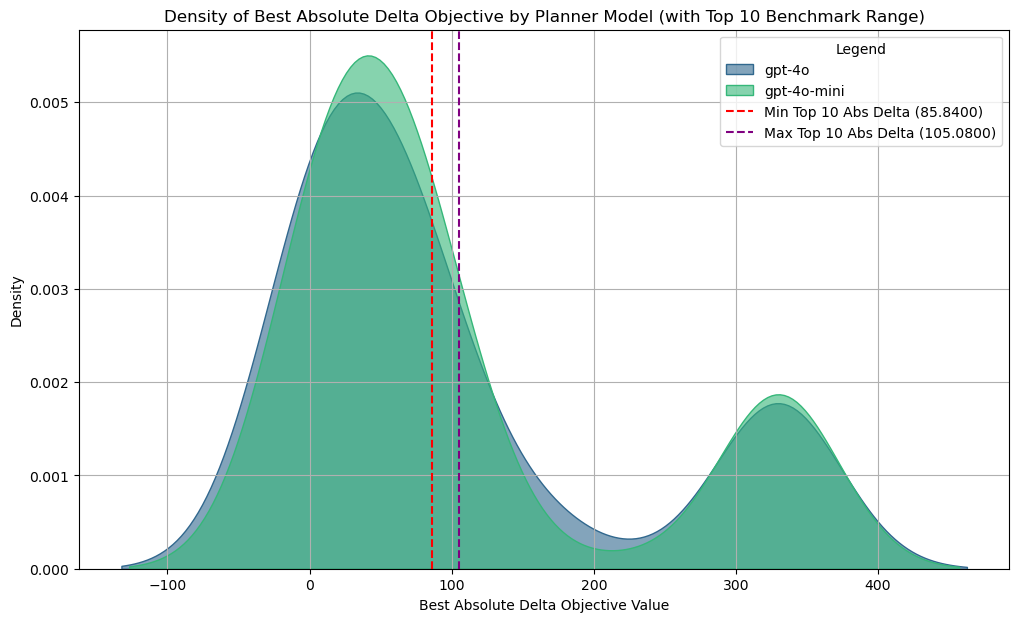

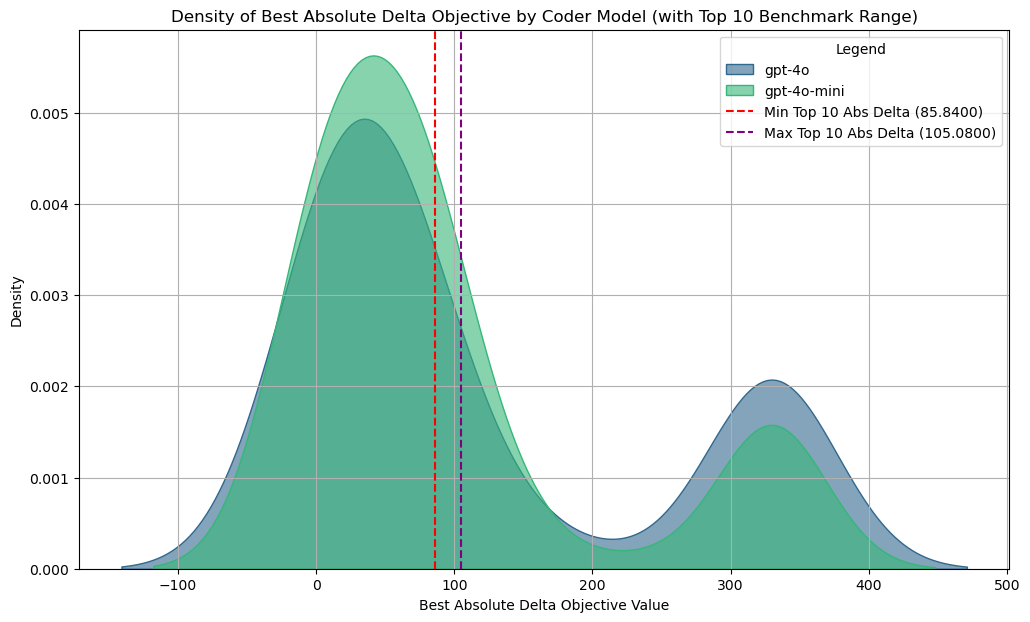

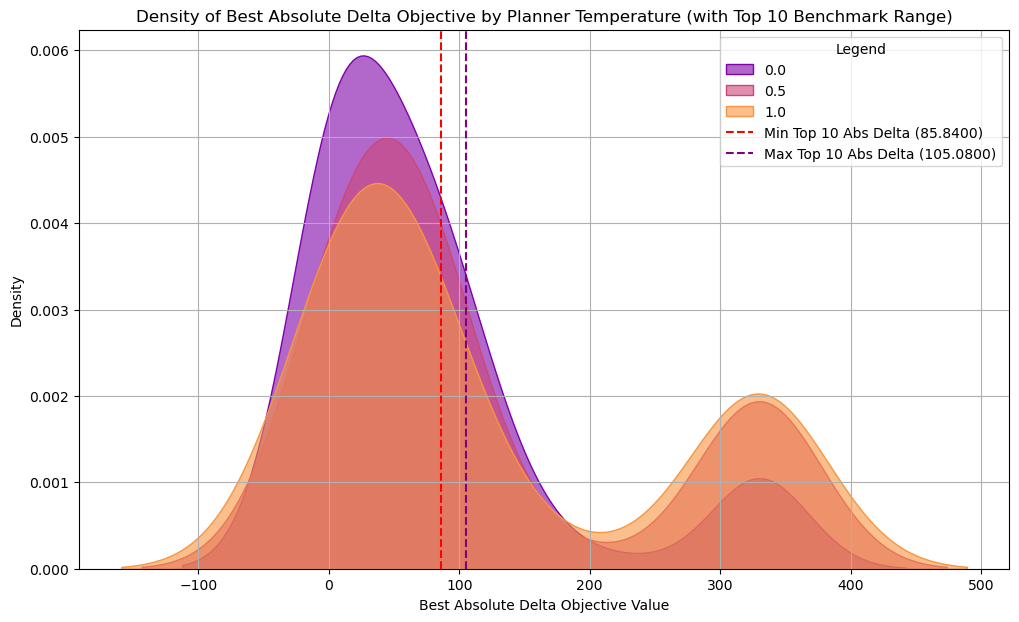

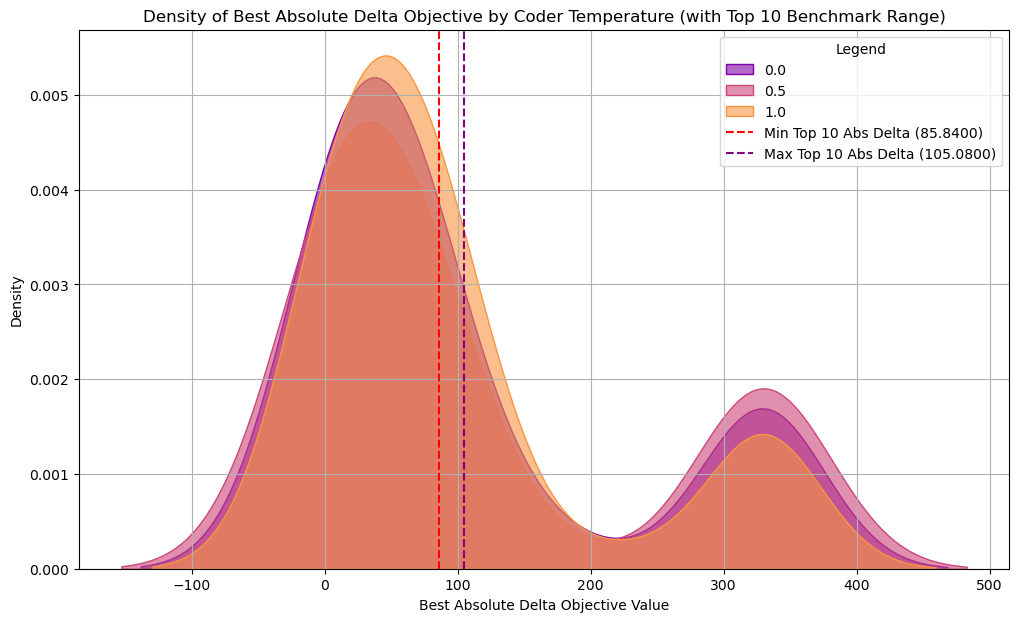

In [51]:
# Ensure 'abs_delta_obj' is available in df_all_agents
if 'abs_delta_obj' not in df_all_agents.columns:
    df_all_agents['abs_delta_obj'] = df_all_agents['delta_obj'].abs()

# --- 1. Calculate Top K Benchmark Range ---
K_coverage = 10 # Define K for top scenarios, as per your example

# Get the top K benchmark scenarios by absolute delta_obj
# Assuming df_benchmark has 'delta_obj' column
top_k_benchmark_deltas = df_benchmark.sort_values(by='delta_obj', key=abs, ascending=False).head(K_coverage)

# Get the range of delta_obj values for these top K scenarios
min_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().min()
max_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().max()

print(f"\nTop {K_coverage} Benchmark Scenarios (Absolute Delta Objective Range):")
print(f"Min Abs Delta: {min_top_k_abs_delta:.4f}, Max Abs Delta: {max_top_k_abs_delta:.4f}")

# --- 2. Determine Best Performance per Agent Run ---
# Group by run_group_label and run_id to get the best (minimum) abs_delta_obj for each individual run
best_abs_delta_per_run = df_all_agents.groupby(['run_group_label', 'run_id'])['abs_delta_obj'].min().reset_index()
best_abs_delta_per_run.rename(columns={'abs_delta_obj': 'best_abs_delta_obj'}, inplace=True)

# --- 3. Merge Configuration Data ---
# Merge with df_all_agents to get the model and temperature columns for each run_id
# Take the first occurrence of each run_id to get its config, as config is constant per run_group_label
run_configs = df_all_agents[['run_group_label', 'run_id', 'planner_model', 'coder_model', 'planner_temperature', 'coder_temperature']].drop_duplicates(subset=['run_group_label', 'run_id'])
df_runs_with_config = pd.merge(best_abs_delta_per_run, run_configs, on=['run_group_label', 'run_id'], how='left')

# --- 4. Filter Data for Plotting ---
# Filter for specified models and temperatures
allowed_models = ['gpt-4o', 'gpt-4o-mini']
allowed_temps = [0.0, 0.5, 1.0] # Ensure these match your data types (float)

df_plot = df_runs_with_config[
    (df_runs_with_config['planner_model'].isin(allowed_models)) &
    (df_runs_with_config['coder_model'].isin(allowed_models)) &
    (df_runs_with_config['planner_temperature'].isin(allowed_temps)) &
    (df_runs_with_config['coder_temperature'].isin(allowed_temps))
].copy()

# --- Convert Temperature Columns to String for clearer legend labels ---
df_plot['planner_temperature_str'] = df_plot['planner_temperature'].astype(str)
df_plot['coder_temperature_str'] = df_plot['coder_temperature'].astype(str)


# --- 5. Create Density Plots (Combined Legend) ---

# Plot by Planner Model
plt.figure(figsize=(12, 7))
ax = plt.gca() # Get current axes
unique_planner_models = df_plot['planner_model'].unique()
colors = sns.color_palette('viridis', n_colors=len(unique_planner_models))
for i, model in enumerate(sorted(unique_planner_models)):
    subset = df_plot[df_plot['planner_model'] == model]
    sns.kdeplot(data=subset, x='best_abs_delta_obj', fill=True, common_norm=False, color=colors[i], alpha=0.6, label=model, ax=ax)

# Add axvline with labels
ax.axvline(min_top_k_abs_delta, color='red', linestyle='--', label=f'Min Top {K_coverage} Abs Delta ({min_top_k_abs_delta:.4f})')
ax.axvline(max_top_k_abs_delta, color='purple', linestyle='--', label=f'Max Top {K_coverage} Abs Delta ({max_top_k_abs_delta:.4f})')

ax.set_title(f'Density of Best Absolute Delta Objective by Planner Model (with Top {K_coverage} Benchmark Range)')
ax.set_xlabel('Best Absolute Delta Objective Value')
ax.set_ylabel('Density')
ax.grid(True)

# Get all handles and labels and create a single legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Legend') # You can customize the title
plt.show()

# Plot by Coder Model
plt.figure(figsize=(12, 7))
ax = plt.gca() # Get current axes
unique_coder_models = df_plot['coder_model'].unique()
colors = sns.color_palette('viridis', n_colors=len(unique_coder_models))
for i, model in enumerate(sorted(unique_coder_models)):
    subset = df_plot[df_plot['coder_model'] == model]
    sns.kdeplot(data=subset, x='best_abs_delta_obj', fill=True, common_norm=False, color=colors[i], alpha=0.6, label=model, ax=ax)

# Add axvline with labels
ax.axvline(min_top_k_abs_delta, color='red', linestyle='--', label=f'Min Top {K_coverage} Abs Delta ({min_top_k_abs_delta:.4f})')
ax.axvline(max_top_k_abs_delta, color='purple', linestyle='--', label=f'Max Top {K_coverage} Abs Delta ({max_top_k_abs_delta:.4f})')

ax.set_title(f'Density of Best Absolute Delta Objective by Coder Model (with Top {K_coverage} Benchmark Range)')
ax.set_xlabel('Best Absolute Delta Objective Value')
ax.set_ylabel('Density')
ax.grid(True)

# Get all handles and labels and create a single legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Legend')
plt.show()

# Plot by Planner Temperature (using string version for hue)
plt.figure(figsize=(12, 7))
ax = plt.gca() # Get current axes
unique_planner_temps = df_plot['planner_temperature_str'].unique()
colors = sns.color_palette('plasma', n_colors=len(unique_planner_temps))
for i, temp_str in enumerate(sorted(unique_planner_temps)):
    subset = df_plot[df_plot['planner_temperature_str'] == temp_str]
    sns.kdeplot(data=subset, x='best_abs_delta_obj', fill=True, common_norm=False, color=colors[i], alpha=0.6, label=temp_str, ax=ax)

# Add axvline with labels
ax.axvline(min_top_k_abs_delta, color='red', linestyle='--', label=f'Min Top {K_coverage} Abs Delta ({min_top_k_abs_delta:.4f})')
ax.axvline(max_top_k_abs_delta, color='purple', linestyle='--', label=f'Max Top {K_coverage} Abs Delta ({max_top_k_abs_delta:.4f})')

ax.set_title(f'Density of Best Absolute Delta Objective by Planner Temperature (with Top {K_coverage} Benchmark Range)')
ax.set_xlabel('Best Absolute Delta Objective Value')
ax.set_ylabel('Density')
ax.grid(True)

# Get all handles and labels and create a single legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Legend')
plt.show()

# Plot by Coder Temperature (using string version for hue)
plt.figure(figsize=(12, 7))
ax = plt.gca() # Get current axes
unique_coder_temps = df_plot['coder_temperature_str'].unique()
colors = sns.color_palette('plasma', n_colors=len(unique_coder_temps))
for i, temp_str in enumerate(sorted(unique_coder_temps)):
    subset = df_plot[df_plot['coder_temperature_str'] == temp_str]
    sns.kdeplot(data=subset, x='best_abs_delta_obj', fill=True, common_norm=False, color=colors[i], alpha=0.6, label=temp_str, ax=ax)

# Add axvline with labels
ax.axvline(min_top_k_abs_delta, color='red', linestyle='--', label=f'Min Top {K_coverage} Abs Delta ({min_top_k_abs_delta:.4f})')
ax.axvline(max_top_k_abs_delta, color='purple', linestyle='--', label=f'Max Top {K_coverage} Abs Delta ({max_top_k_abs_delta:.4f})')

ax.set_title(f'Density of Best Absolute Delta Objective by Coder Temperature (with Top {K_coverage} Benchmark Range)')
ax.set_xlabel('Best Absolute Delta Objective Value')
ax.set_ylabel('Density')
ax.grid(True)

# Get all handles and labels and create a single legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Legend')
plt.show()

## Table showing different scenarios runs

In [52]:
import random

# --- Configuration for filtering and K scenarios ---
allowed_models = ['gpt-4o', 'gpt-4o-mini']
allowed_temps = [0.0, 0.5, 1.0] # Ensure these match your data types (float)
K_scenarios = 5 # Number of top scenarios to display for each selected run

# --- 1. Filter Data for relevant configurations ---
df_filtered_configs = df_all_agents[
    (df_all_agents['planner_model'].isin(allowed_models)) &
    (df_all_agents['planner_temperature'].isin(allowed_temps))
].copy()

# Ensure 'scenario_text' is not empty or NaN for relevant analysis
df_filtered_configs = df_filtered_configs.dropna(subset=['scenario_text', 'abs_delta_obj'])

# --- 2. Select One Random Run per Configuration ---
selected_runs_data = []
unique_planner_configs = df_filtered_configs[['planner_model', 'planner_temperature']].drop_duplicates()

for index, config_row in unique_planner_configs.iterrows():
    model = config_row['planner_model']
    temp = config_row['planner_temperature']

    # Get all run_ids for this specific planner configuration
    runs_for_config = df_filtered_configs[
        (df_filtered_configs['planner_model'] == model) &
        (df_filtered_configs['planner_temperature'] == temp)
    ]['run_id'].unique()

    if len(runs_for_config) > 0:
        # Randomly select one run_id
        selected_run_id = random.choice(runs_for_config)

        # Get all scenarios for this selected run_id
        scenarios_in_run = df_filtered_configs[
            (df_filtered_configs['run_id'] == selected_run_id)
        ].sort_values(by='abs_delta_obj', ascending=True) # Sort by abs_delta_obj ascending (lower is better)

        # Take the top K_scenarios
        top_scenarios = scenarios_in_run.head(K_scenarios)

        for _, scenario_row in top_scenarios.iterrows():
            selected_runs_data.append({
                'Planner Model': model,
                'Planner Temp.': temp,
                'Run ID': selected_run_id,
                'Scenario Text': scenario_row['scenario_text'],
                'Objective Value': scenario_row['objective_value'],
                'Abs Delta Objective': scenario_row['abs_delta_obj']
            })
    else:
        print(f"No runs found for Planner Model: {model}, Temp: {temp}")

df_top_scenarios_table = pd.DataFrame(selected_runs_data)

# --- 3. Generate LaTeX Table ---
latex_table_string_scenarios = """
\\begin{{table}}[H]
\\centering
\\caption{{Example Scenarios for Selected Agent Configurations (VRP Run), random run picked for each configuration.}}
\\label{{tab:top_k_scenarios}}
\\small
\\begin{{tabular}}{{@{{}}lllrll@{{}}}}
\\toprule
\\textbf{{Planner Model}} & \\textbf{{Temp.}} & \\textbf{{Run ID}} & \\textbf{{Abs Delta Obj}} & \\textbf{{Objective Value}} & \\textbf{{Scenario Text}} \\\\
\\midrule
""".format(K_scenarios=K_scenarios)

current_model_temp = None
for index, row in df_top_scenarios_table.iterrows():
    model_temp_combo = (row['Planner Model'], row['Planner Temp.'])
    if model_temp_combo != current_model_temp:
        if current_model_temp is not None:
            latex_table_string_scenarios += "\\addlinespace\n"
        latex_table_string_scenarios += (
            f"\\multicolumn{{6}}{{l}}{{\\textbf{{Planner Model: \\texttt{{{row['Planner Model']}}}, "
            f"Temp: {row['Planner Temp.']:.1f}, Selected Run: \\texttt{{{row['Run ID']}}}}} \\\\}}\n"
        )
        current_model_temp = model_temp_combo

    # Truncate scenario text if too long for table
    scenario_text_display = row['Scenario Text']
    if len(scenario_text_display) > 100: # Adjust max length as needed
        scenario_text_display = scenario_text_display[:97] + "..."
    
    # Escape LaTeX special characters in scenario text
    scenario_text_display = scenario_text_display.replace('_', '\\_').replace('%', '\\%').replace('&', '\\&')
    scenario_text_display = scenario_text_display.replace('#', '\\#').replace('{', '\\{').replace('}', '\\}')
    scenario_text_display = scenario_text_display.replace('~', '\\textasciitilde{}').replace('^', '\\textasciicircum{}')
    scenario_text_display = scenario_text_display.replace('<', '$<$').replace('>', '$>$') # Math mode for < >

    latex_table_string_scenarios += (
        f"& & & {row['Abs Delta Objective']:.4f} & {row['Objective Value']:.2f} & {scenario_text_display} \\\\\n"
    )

latex_table_string_scenarios += """
\\bottomrule
\\end{tabular}
\\end{table}
"""

print(latex_table_string_scenarios)



\begin{table}[H]
\centering
\caption{Example Scenarios for Selected Agent Configurations (VRP Run), random run picked for each configuration.}
\label{tab:top_k_scenarios}
\small
\begin{tabular}{@{}lllrll@{}}
\toprule
\textbf{Planner Model} & \textbf{Temp.} & \textbf{Run ID} & \textbf{Abs Delta Obj} & \textbf{Objective Value} & \textbf{Scenario Text} \\
\midrule
\multicolumn{6}{l}{\textbf{Planner Model: \texttt{gpt-4o-mini}, Temp: 0.5, Selected Run: \texttt{run_id_20250603_013229_it_5}} \\}
& & & 0.0000 & 330.10 & Increase the number of vehicles from 2 to 5, which may lead to a significant reduction in total d... \\
\addlinespace
\multicolumn{6}{l}{\textbf{Planner Model: \texttt{gpt-4o-mini}, Temp: 0.0, Selected Run: \texttt{run_id_20250603_012550_it_0}} \\}
& & & 86.7900 & 416.89 & Reduce the vehicle capacity from 50 to 30, which may lead to infeasibility due to increased deman... \\
\addlinespace
\multicolumn{6}{l}{\textbf{Planner Model: \texttt{gpt-4o-mini}, Temp: 1.0, Selected Run:

In [53]:
df_top_scenarios_table.head(6)

,Planner Model,Planner Temp.,Run ID,Scenario Text,Objective Value,Abs Delta Objective
0,gpt-4o-mini,0.5,run_id_20250603_013229_it_5,"Increase the number of vehicles from 2 to 5, w...",330.10,0.00
1,gpt-4o-mini,0.0,run_id_20250603_012550_it_0,"Reduce the vehicle capacity from 50 to 30, whi...",416.89,86.79
2,gpt-4o-mini,1.0,run_id_20250603_013600_it_4,Increase the number of available vehicles from...,330.10,0.00
3,gpt-4o,0.5,run_id_20250603_015457_it_7,"""Increase the demand at customer locations 5, ...",382.11,52.01
4,gpt-4o,0.0,run_id_20250603_014711_it_6,"""Increase the demand at customer locations 6 a...",387.01,56.91
5,gpt-4o,1.0,run_id_20250603_020019_it_3,Increase all customer demands by 100% to evalu...,0.00,330.10
